# In this assignment, a simple ConvNet is implemented and trained to predict the language of a surname from its spelling in English.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm
from scipy.linalg import block_diag
from scipy.io import loadmat
from sklearn.metrics import confusion_matrix

## 1. ConvNet class implementation

In [58]:
class ConvNet:
    """
    A simple ConvNet implementation with 2 convolutional layers 
    followed by a fully connected layer and a softmax output 
    layer.
    
    Attributes:
        n: A list of the number of filters applied at each convo-
            lutional layer.
        k: A list of the width of the filter window applied in each
            convolutional layer.
        input_dim: dimensionality of input (number of unique characters)
        output_dim: dimensionality of output
        max_length: maximum number of characters in an input
        nlen_list: List with the number of columns of the input when in its original form
            before being vectorized, for each layer.
        eta: initial learning rate value
        rho: momentum constant term
        F: list of filters/weights for each one of the convolutional
            layers.
        W: Weights of the fully connected layer
        
    """
    
    def __init__(self, n, k, output_dim, input_dim, nlen, eta = 0.001, rho = 0.9, he_init = False):
        """
        Initializes the convolutional neural network
    
        Args:
            he_init: When True He-initialization is performed for the weights
            nlen: Number of columns of the input when in its original form
            before being vectorized.
        Raises:
            Exception if the size of n and k is not the same.
        """
        if(len(n) != len(k)):
            raise Exception("The number of layers specified by <n> " \
                            "and <k> should be equal.")
        self.n = list(n)
        self.k = list(k)
        
        self.input_dim = input_dim
        self.max_length = nlen
        
        # TODO: Change He initialization for first layer due to the sparse nature of the input
        self.F = []
        if he_init is True:
            self.F.append(np.random.normal(0, np.sqrt(2/self.k[0]), (input_dim, self.k[0], self.n[0])))
        else:
            self.F.append(np.random.normal(0, 1, (input_dim, self.k[0], self.n[0])))
        self.nlen_list = [nlen - self.k[0] + 1]
        
        for i in range(1, len(n)):
            if he_init is True:
                self.F.append(np.random.normal(0, np.sqrt(2/(self.n[i - 1] * self.k[i])), (self.n[i - 1], self.k[i], self.n[i])))
            else:
                self.F.append(np.random.normal(0, 1, (self.n[i - 1], self.k[i], self.n[i])))
            self.nlen_list.append(self.nlen_list[-1] - self.k[1] + 1)
        fsize = self.n[-1] * self.nlen_list[-1]
        if he_init is True:
            self.W = np.random.normal(0, np.sqrt(2/self.nlen_list[-1] * self.n[-1]), (output_dim, fsize))
        else:
            self.W = np.random.normal(0, 1, (output_dim, fsize))
    
    def softmax(self, s):
        """
        Implementation of the softmax activation function

        Args:
            s: an 1xd vector of a classifier's outputs

        Returns:
            An 1xd vector with the results of softmax given the input
            vector s.
        """
        exponents = np.exp(s - np.max(s, axis = 0)) # Max subtraction for numerical stability
        output_exp_sum = np.sum(exponents, axis = 0)
        p = exponents / output_exp_sum
        return p

    def constructFilterMatrix(self, F, nlen):
        """
        Constructs the matrix of the filters of a layer used to
        perform the convolution by matrix multiplication.
        
        Args:
            F: A N x k x nf containing the convolutional filters
                of a certain layer where N is the height of the convo-
                lutional filter, k is its width and nf is the number of
                filters in the layer.
            nlen: Number of columns in the input of that layer. 
        
        Returns:
            An (nlen - k + 1) * nf x nlen * N matrix that can be used to
            perform the convolution when multiplied by the
            vectorized input.
        """
        nf = F.shape[2]
        vec_filters = F.transpose(2,1,0).reshape(nf, F.shape[0] * F.shape[1])
        MF_matrix = np.zeros(((nlen - F.shape[1] + 1) * nf, nlen * F.shape[0]))
        cur_column = 0
        # For each time the filters are applied
        for i in range(nlen - F.shape[1] + 1):
            # Fill in the zero slots of the MF_Matrix with the vectorized filters
            MF_matrix[i * nf: i * nf + nf, cur_column *  F.shape[0]: cur_column *  F.shape[0] + vec_filters.shape[1]] = vec_filters
            cur_column += 1
        return MF_matrix
        
    def makeMXMatrix(self, vec_input, height, width, nf, nlen):
        """
        Computes the input matrix used for the convolutions during the 
        back-propagation.
        
        Args:
            vec_input: Vectorized version of the input to the convolutional
                layer.
            height: corresponding height of the filter
            width: corresponding width of the filter
            filter_no: number of filters to be applied
            nlen: Number of columns in the input of that layer. 
        Returns:
            A (nlen - k + 1) * filter_no x k * filter_no * height with the
            results of the convolutions.
        """
        MX_Matrix = np.zeros(((nlen - width + 1) * nf, width * nf * height))
        cur_column = 0
        for i in range(nlen - width + 1):
            # Define block diagonal matrix with the inputs to be used in this convolution on the diagonal
            MX_Matrix[i * nf : i * nf + nf, :] = \
                block_diag(*[vec_input[cur_column * height: cur_column * height + width * height] for j in range(nf)]) 
            cur_column += 1
        return MX_Matrix
    
    def cross_entropy_loss(self, X, Y, MFs):
        """
        Calculates the cross entropy loss
        """
        log_X = np.multiply(Y , self.forwardPass(X, MFs)[0]).sum(axis=0)
        log_X[log_X == 0] = np.finfo(float).eps
        return -np.log(log_X)


    
    def computeLoss(self, X_batch, Y_batch, MFs):
        """
        Computes the loss of the network given a batch of data.
        
        Args:
            X_batch: NxD matrix with N data sample inputs
            Y_batch: NxM matrix with N data sample outputs
        
        Returns:
            A scalar float value corresponding to the loss.
        """        
        return np.mean(self.cross_entropy_loss(X_batch, Y_batch, MFs))# + lamda * np.sum(self.W ** 2)

    def computeAccuracy(self, X, y, MFs):
        """
        Computes the accuracy of the network.

        Args:
            X: Input matrix
            y: Output labels

        Returns:
            The accuracy of the network (i.e. the percentage of
            correctly classified inputs in X).

        """
        softmax_outputs = self.forwardPass(X, MFs)[0] # Get probability distribution of outputs
        # Reduce to a vector of the labels with the highest probability
        predictions = np.argmax(softmax_outputs, axis = 0)
        accuracy = (predictions == y).mean()
        return accuracy

    def forwardPass(self, X_batch, MFs):
        """
        Performs a forward pass and returns the result:
        
        Args:
            X_batch: NxD matrix with N data sample inputs
            MFs: Matrices needed to perform convolution as 
                matrix multiplication.
            
        Returns:
            A matrix with the predicted one-hot representations along with the outputs
            of the first and second layer as well as the MF matrices calculated.
        """
        
        # Apply first convolutional layer to input data followed by a ReLU activation
        X_batch1 = MFs[0].dot(X_batch)
        X_batch1[X_batch1 < 0.0] = 0.0
        
        # Apply second convolutional layer to input data followed by a ReLU activation
        X_batch2 = MFs[1].dot(X_batch1)
        X_batch2[X_batch2 < 0.0] = 0.0
        
        # Apply the fully connected layer
        output = self.W.dot(X_batch2)
        # Apply softmax
        P_batch = self.softmax(output)
        return P_batch, X_batch1, X_batch2
    
    def backwardPass(self, Y_batch, P_batch, X_batch, X_batch1, X_batch2, MFs):
        """
        Performs a backward pass and returns the gradients:
        
        Args:
            Y_batch: NxM matrix with N data sample outputs
            P_batch: Output after the softmax activation layer
            X_batch2: Output of the second convolutional layer after the ReLU.
            X_batch1: Output of the first convolutional layer after the ReLU.
            X_batch: Original batch with the inputs.
            MFs: Matrices needed to perform convolution as 
                matrix multiplication.
            
        Returns:
            The gradients of the weights of each layer (i.e. grad_F1, grad_F2, grad_W).
        """
        # Initialize all gradients to zero
        grad_W = np.zeros(self.W.shape) 
        grad_F1 = np.zeros(self.F[0].shape)
        grad_F2 = np.zeros(self.F[1].shape)
        
        # Compute gradient of W
        n = Y_batch.shape[1]
        G_batch = -(Y_batch - P_batch)
        grad_W = G_batch.dot(X_batch2.T) / n
        
        
        # Propagate gradient through fully connected layer and ReLU of 2nd layer
        G_batch = self.W.T.dot(G_batch)
        G_batch *= np.where(X_batch2 > 0, 1, 0)
        
        # Compute gradient of the second layer's filters
        n = X_batch1.shape[1]
        for j in range(n):
            g_j = G_batch[:,j]
            x_j = X_batch1[:,j]
            MX_matrix = self.makeMXMatrix(x_j, *self.F[1].shape, self.nlen_list[0])
            v = g_j.T.dot(MX_matrix)
            grad_F2 += v.reshape(grad_F2.shape, order='F')
        grad_F2 /= n
        
        # Propagate gradient through second convolutional layer and ReLU of 1st layer
        G_batch = MFs[1].T.dot(G_batch)
        G_batch *= np.where(X_batch1 > 0, 1, 0)
        
        # Compute gradient of the first layer's filters
        n = X_batch.shape[1]
        for j in range(n):
            g_j = G_batch[:,j]
            x_j = X_batch[:,j]
            MX_matrix = self.makeMXMatrix(x_j, *self.F[0].shape, self.max_length)
            v = g_j.T.dot(MX_matrix)
            grad_F1 += v.reshape(grad_F1.shape, order='F')
        grad_F1 /= n       
        
        return grad_F1, grad_F2, grad_W
    


    def compute_grad_num_slow(self, X_batch, Y_batch, h = 1e-5):
        '''Centered difference gradient'''
        # Initialize all gradients to zero
        grad_W = np.zeros(self.W.shape) 
        grad_F1 = np.zeros(self.F[0].shape)
        grad_F2 = np.zeros(self.F[1].shape)

        MFs = [self.constructFilterMatrix(self.F[0], self.max_length)]
        MFs.append(self.constructFilterMatrix(self.F[1], self.nlen_list[0]))
        
        for j in tqdm(range(self.W.shape[0])):
            for k in range(self.W.shape[1]):
                self.W[j, k] -= h
                c1 = self.computeLoss(X_batch, Y_batch, MFs);
                self.W[j, k] += 2 * h
                c2 = self.computeLoss(X_batch, Y_batch, MFs);
                self.W[j, k] -= h
                grad_W[j, k] = (c2-c1) / (2 * h)
        
        
        for j in tqdm(range(self.F[1].shape[0])):
            for k in range(self.F[1].shape[1]):
                for i in range(self.F[1].shape[2]):
                    self.F[1][j, k, i] -= h
                    MFs = [self.constructFilterMatrix(self.F[0], self.max_length)]
                    MFs.append(self.constructFilterMatrix(self.F[1], self.nlen_list[0])) 
                    c1 = self.computeLoss(X_batch, Y_batch, MFs);

                    self.F[1][j, k, i]  += 2 * h
                    MFs = [self.constructFilterMatrix(self.F[0], self.max_length)]
                    MFs.append(self.constructFilterMatrix(self.F[1], self.nlen_list[0])) 
                    c2= self.computeLoss(X_batch, Y_batch, MFs);

                    self.F[1][j, k, i]  -= h
                    grad_F2[j, k, i]  = (c2-c1) / (2 * h)

        
        for j in tqdm(range(self.F[0].shape[0])):
            for k in range(self.F[0].shape[1]):
                for i in range(self.F[0].shape[2]):
                    self.F[0][j, k, i]  -= h
                    MFs = [self.constructFilterMatrix(self.F[0], self.max_length)]
                    MFs.append(self.constructFilterMatrix(self.F[1], self.nlen_list[0])) 
                    c1 = self.computeLoss(X_batch, Y_batch, MFs);

                    self.F[0][j, k, i]  += 2 * h
                    MFs = [self.constructFilterMatrix(self.F[0], self.max_length)]
                    MFs.append(self.constructFilterMatrix(self.F[1], self.nlen_list[0])) 
                    c2= self.computeLoss(X_batch, Y_batch, MFs);

                    self.F[0][j, k, i] -= h
                    grad_F1[j, k, i] = (c2-c1) / (2 * h)

                
        return grad_F1, grad_F2, grad_W
    
    def getClassBins(self, y):
        K = len(np.unique(y))
        bins = []
        for i in range(K):
            bins.append([j for j in range(len(y)) if y[j] == i])
        return bins
    
    def miniBatchGD(self, X, Y, GDparams, verbose = False, X_val = None, Y_val = None, tol = 1e-10, n_update = 1, patience = 5,
                   imbalanced_set = False):
        """
        Implementation of mini-batch gradient descent.

         Args:
            X: Training input matrix
            Y: Training set desired output matrix
            GDparams: Object of the class Params with the hyperparameters
                used for learning.
            verbose: Prints info in each iteration about the progress of
                training when equal to True.
            X_val: Validation set input matrix
            Y_val: Validation set desired output matrix
            n_update: After each <n_update> updates the validation and training
                accuracy and loss are computed.

        Returns:
            The following tuple is returned where the validation lists
            are empty if no validation set is given: (training_loss_list,
            validation_loss_list, training_acc_list, validation_acc_list).
        """
        results = ([],[],[],[])
        mini_batch_count = X.shape[1] // GDparams.n_batch
        y = np.argmax(Y, axis = 0)
        K = len(np.unique(y))
        
        if imbalanced_set:
            bins = self.getClassBins(y)
            class_samples = [len(bin) for bin in bins]
            min_samples = min(class_samples)
            
        
        MFs = [self.constructFilterMatrix(self.F[0], self.max_length)]
        MFs.append(self.constructFilterMatrix(self.F[1], self.nlen_list[0]))
        
        if(X_val is not None and Y_val is not None):
            y_val = np.argmax(Y_val, axis = 0)
        results[0].append(self.computeLoss(X, Y, MFs))
        results[2].append(self.computeAccuracy(X, y, MFs))
        
        if(X_val is not None and Y_val is not None):
            results[1].append(self.computeLoss(X_val, Y_val, MFs))
            results[3].append(self.computeAccuracy(X_val, y_val, MFs))
            best_acc = results[3][-1]
            best_F = list(self.F)
            best_W = np.copy(self.W)
            early_stop_counter = patience
            
        if(verbose):
                print("Starting state ")
                print("    Training cost: " + str(results[0][-1]))
                print("    Training accuracy: " + str(results[2][-1]))
                if(X_val is not None and Y_val is not None):
                    print("    Validation cost: " + str(results[1][-1]))
                    print("    Validation accuracy: " + str(results[3][-1]))
                    
        # If momentum is used
        if GDparams.rho != 0.0:
            # Create zero matrix for each parameter
            V_W = np.zeros(self.W.shape)
            V_F2 = np.zeros(self.F[1].shape)
            V_F1 = np.zeros(self.F[0].shape)
                    
        learning_rate = GDparams.eta
        steps = 0
        
        if imbalanced_set:
            X_ = np.copy(X)
            Y_ = np.copy(Y)
            y_ = np.copy(y)
        for i in tqdm(range(GDparams.n_epochs)):
            if imbalanced_set:
                indices = []                
                for k in range(K):
                    indices.append(np.random.choice(bins[k], size = min_samples, replace=False))
                indices = np.array(indices).flatten()
                np.random.shuffle(indices)
                X = np.copy(X_[:,indices])
                Y = np.copy(Y_[:,indices])
                y = np.argmax(Y, axis = 0)
                mini_batch_count = X.shape[1] // GDparams.n_batch
                

            for j in range(mini_batch_count):
                steps += 1                    
                if(j < mini_batch_count - 1):
                    start = j * GDparams.n_batch
                    end = start + GDparams.n_batch
                    mini_batch_input = X[:,start:end]
                    mini_batch_output = Y[:,start:end]
                else:
                    # Take the remaining samples in the last mini batch
                    mini_batch_input = X[:,j * GDparams.n_batch:]
                    mini_batch_output = Y[:,j * GDparams.n_batch:]

                # Construct MF Matrices
                MFs = [self.constructFilterMatrix(self.F[0], self.max_length)]
                MFs.append(self.constructFilterMatrix(self.F[1], self.nlen_list[0]))
                P_batch, X_batch1, X_batch2 = self.forwardPass(mini_batch_input, MFs)
                grad_F1, grad_F2, grad_W = self.backwardPass(mini_batch_output, P_batch, mini_batch_input,\
                                                             X_batch1, X_batch2, MFs)
                
                # Converge if all gradients are zero
                if np.all(grad_W < tol) == 0 and np.all(grad_F1 < tol) and np.all(grad_F2 < tol):
                    print("Learning converged at epoch " + str(i))
                    break              
                
                if GDparams.rho == 0.0:
                    self.W -= learning_rate * grad_W
                    self.F[1] -= learning_rate * grad_F2
                    self.F[0] -= learning_rate * grad_F1
                else:
                    V_W = GDparams.rho * V_W + learning_rate * grad_W
                    V_F2 = GDparams.rho * V_F2 + learning_rate * grad_F2
                    V_F1 = GDparams.rho * V_F1 + learning_rate * grad_F1
                    self.W -= V_W
                    self.F[1] -= V_F2
                    self.F[0] -= V_F1
                
                if steps % n_update == 0:
                    if imbalanced_set:
                        X = np.copy(X_)
                        Y = np.copy(Y_)
                        y = np.copy(y_)
                    results[0].append(self.computeLoss(X, Y, MFs))
                    results[2].append(self.computeAccuracy(X, y, MFs))
                    if(X_val is not None and Y_val is not None):
                        results[1].append(self.computeLoss(X_val, Y_val, MFs))
                        results[3].append(self.computeAccuracy(X_val, y_val, MFs))
                        if results[3][-1] > best_acc:
                            early_stop_counter = patience
                            best_acc = results[3][-1]
                            best_F = list(self.F)
                            best_W = np.copy(self.W)
                        else:
                            early_stop_counter -= 1
                            if early_stop_counter == 0:
                                break
                                
                    if(verbose):
                        print("Iteration " + str(i))
                        print("    Training cost: " + str(results[0][-1]))
                        print("    Training accuracy: " + str(results[2][-1]))
                        if(X_val is not None and Y_val is not None):
                            print("    Validation cost: " + str(results[1][-1]))
                            print("    Validation accuracy: " + str(results[3][-1]))
            # Decay the learning rate
            learning_rate *= GDparams.decay_rate
            if early_stop_counter == 0:
                                break
            
    
        self.F = best_F
        self.W = best_W
        
        return results
    
    
  

D:\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [3]:
class Params:
    """
    Class containing hyperparameters used for
    gradient descent learning.
    
    Attributes:
        n_batch: Number of samples in each mini-batch.
        eta: Learning rate
        n_epochs: Maximum number of learning epochs.
        decay_rate: The percentage of decay of the learning rate after each epoch, i.e.
            a factor less than 1 by which the learning rate gets multiplied after each 
            epoch.
        rho: percentage of use of the gradients of previous turns in learning to add momentum
    """
    def __init__(self, n_batch, eta, n_epochs, decay_rate = 1.0, rho = 0.0):
        """ Constructor """
        self.n_batch = n_batch
        self.eta = eta
        self.n_epochs = n_epochs
        self.decay_rate = decay_rate
        self.rho = rho

In [4]:
def getRelativeErrors(grad1, grad2):
    """
    Computes the relative errors of grad_1 and grad_2 gradients
    """
    abs_diff = np.absolute(grad1 - grad2) 
    abs_sum = np.absolute(grad1) + np.absolute(grad2)
    max_elems = np.where(abs_sum > np.finfo(float).eps, abs_sum, np.finfo(float).eps)
    relativeErrors = abs_diff / max_elems
    return relativeErrors

In [5]:
def makePlots(tr_losses, val_losses, tr_accuracies, val_accuracies, n_updates):
    plt.subplot(1,2,1)
    plt.plot([i*n_updates for i in range(len(tr_losses))], tr_losses, 'r-', label='Train')
    plt.plot([i*n_updates for i in range(len(val_losses))], val_losses, 'b-', label='Validation')
    plt.title('Cost function')
    plt.xlabel('Update steps')
    plt.ylabel('Cost value')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot([i*n_updates for i in range(len(tr_accuracies))], tr_accuracies, 'r-', label='Training data')
    plt.plot([i*n_updates for i in range(len(val_accuracies))], val_accuracies, 'b-', label='Validation data')
    plt.title('Accuracy')
    plt.xlabel('Update steps')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [6]:
def plot_confusion_matrix(convNet, inv_class_dictionary, Y, X,
                      title='Confusion matrix', normalize = False,
                      cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    K = len(inv_class_dictionary)
    classes = [inv_class_dictionary[i + 1] for i in range(K)]
    MFs = [convNet.constructFilterMatrix(convNet.F[0], convNet.max_length)]
    MFs.append(convNet.constructFilterMatrix(convNet.F[1], convNet.nlen_list[0]))
    cm = confusion_matrix(np.argmax(Y, axis = 0), np.argmax(convNet.forwardPass(X, MFs)[0], axis = 0), labels = [i for i in range(K)])

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## 2. Preparing data

In [7]:
def encodeString(string, character_dictionary, max_length):
    """
    One-hot encodes the character string, converting each 
    of its letters to one-hot encoded vectors and stacking
    them from left to right. 
    
    Args:
        name: The string to be encoded.
        character_dictionary: A dictionary which has a unique
            index for each character in the alphabet used by
            the string.
        max_length: maximum length of the string. If the string
            has a length less than max_length, zero columnds are
            added as padding after the encoded character columns.

    
    Returns:
        A C x max_length vector with the one-hot encoded characters
        of the string and possibly zero padding in the last columns
        where C is the number of different characters in the alpha-
        bet used.
    """
    d = len(character_dictionary)
    encoded_string = np.zeros((d, max_length))
    for i in range(len(string)):
        encoded_string[character_dictionary[string[i]],i] = 1
    return encoded_string

In [8]:
def one_hot_encoding(label_id, label_no):
    """
    Returns a one-hot encoded numpy vector with 1 at the index
    of the label and 0 for each other element.
    
    Args:
        label_id: Index of label.
        label_no: Number of total labels.
    
    Returns:
        A one-hot encoded vector with label_no elements.
    """
    vector = np.zeros(label_no) 
    vector[label_id] = 1
    return vector

In [9]:
# Path to the files containing the data
name_path = "ascii_names.txt"
category_labels_path = "category_labels.txt"
# Path to file used to save the inputs after their encoding
save_input_path = "onehot_encoded_inputs.npy"
# Path to file with the indices of the inputs that are going to used in the validation set
val_ind_path = "Validation_Inds.txt"

In [10]:
# Read the data
names = []
labels = []
if(os.path.exists(name_path)):
    with open(name_path,"r") as f:
        for line in tqdm(f):
            entry = line.split()
            names.append(' '.join(entry[:-1]))
            labels.append(entry[-1])
    f.close()
    names = np.array(names)
    labels = np.array(labels, dtype = int) 
else:
    print("Requested file " + name_path + " does not exist.")

20050it [00:00, 978085.55it/s]


In [11]:
# Read the different class names and indices and build a dictionary
if(os.path.exists(category_labels_path)):
    class_names = np.loadtxt(category_labels_path, usecols = 1, dtype = str)
    class_indices = np.loadtxt(category_labels_path, usecols = 0, dtype = int)
    K = len(class_names)
    class_dictionary = {}
    for i in range(K):
        class_dictionary[class_names[i]] = class_indices[i]
    inv_class_dictionary = {v: k for k, v in class_dictionary.items()}
    # Check for correctness
    print(class_dictionary['Arabic'])
    print(inv_class_dictionary[1])
else: 
    print("Requested file " + category_labels_path + " does not exist.")

1
Arabic


### Determine number of unique characters and set up dictionary / Determine maximum length of name in dataset

In [12]:
character_dictionary = {}
unique_idx = 0
max_length = -1
for name in tqdm(names):
    length = len(name)
    if(length > max_length):
        max_length = length
    for i in range(len(name)):
        if(name[i] not in character_dictionary.keys()):
            character_dictionary[name[i]] = unique_idx
            unique_idx += 1
d = len(character_dictionary) # Get number of unique characters

100%|████████████████████████████████| 20050/20050 [00:00<00:00, 471793.61it/s]


In [13]:
print("DIFFERENT UNIQUE CHARACTERS: " + str(d))
print("MAXIMUM NAME LENGTH: " + str(max_length))

DIFFERENT UNIQUE CHARACTERS: 55
MAXIMUM NAME LENGTH: 19


In [14]:
# Build inverse dictionary mapping
inv_character_dictionary = {v: k for k, v in character_dictionary.items()}
# Check for correctness
print(character_dictionary['o'])
print(inv_character_dictionary[2])

2
o


### One-hot encoding and vectorization of the input names

In [15]:
# Encode and save the inputs in a matrix when each column corresponds to a different name
vectorized_input_size = d * max_length
X = np.zeros((vectorized_input_size, names.shape[0]))
for idx, name in enumerate(tqdm(names)):
    X[:,idx] = encodeString(name, character_dictionary, max_length).flatten(order = 'F')

100%|█████████████████████████████████| 20050/20050 [00:00<00:00, 29593.70it/s]


In [16]:
# Save inputs in a file if they are not already saved
if(not os.path.exists(save_input_path)):
    np.save(save_input_path, X)

In [17]:
# Get the indices of the inputs that are going to used in the validation set
if(os.path.exists(val_ind_path)):
    validation_indices = np.loadtxt(val_ind_path, dtype=int)

In [18]:
# One-hot encoding for outputputs
Y = np.array([one_hot_encoding(label - 1, K) for label in labels], order = 'F').T

### Separate data in training and validation samples

In [19]:
# Discard indices that do not correspond to any input
validation_indices = validation_indices[validation_indices < X.shape[1]]
# Take out the validation set
X_val = X[:,validation_indices]
X_tr = np.delete(X, validation_indices, axis = 1)
Y_val = Y[:,validation_indices]
Y_tr = np.delete(Y, validation_indices, axis = 1)
#print(X.shape)
#print(X_tr.shape)
#print(X_val.shape)
#print(Y.shape)
#print(Y_tr.shape)
#print(Y_val.shape)

### Find the $p_y$ values needed to compensate for the imbalanced dataset 

In [20]:
'''
n = [0 for i in range(Y_tr.shape[0])]
# For each sample in the training dataset 
for i in range(X_tr.shape[1]):
    # Get class
    y = np.argmax(Y_tr[:,i])
    # Update class count
    n[y] += 1
# Now the number of samples per class is available and p_y can be computed
p = [0 for i in range(Y_tr.shape[0])]
for i in range(Y_tr.shape[0]):
    p[i] = 1 / (Y_tr.shape[0] * n[i])
'''

'\nn = [0 for i in range(Y_tr.shape[0])]\n# For each sample in the training dataset \nfor i in range(X_tr.shape[1]):\n    # Get class\n    y = np.argmax(Y_tr[:,i])\n    # Update class count\n    n[y] += 1\n# Now the number of samples per class is available and p_y can be computed\np = [0 for i in range(Y_tr.shape[0])]\nfor i in range(Y_tr.shape[0]):\n    p[i] = 1 / (Y_tr.shape[0] * n[i])\n'

## Set hyperparameters & initialize the ConvNet's parameters

In [ ]:
filter_width_constants = [3, 3]
filter_numbers = [5, 5]
K = len(class_dictionary)
conv_net = ConvNet(n = filter_numbers , k = filter_width_constants, output_dim = K, \
                   input_dim = d, nlen = max_length, he_init = True)

In [ ]:
# Debug based on saved filters and convolution outputs
dictionary = loadmat("Debugging_files/DebugInfo")
x_input = dictionary['x_input'].reshape(1, -1)
X_input = dictionary['X_input']
F = dictionary['F']
vecS = dictionary['vecS']
MF_Matrix = conv_net.constructFilterMatrix(F, max_length)
s = MF_Matrix.dot(x_input.reshape(-1, 1)).flatten()
print(np.allclose(s, vecS.flatten()))

In [ ]:
MF_Matrix = conv_net.constructFilterMatrix(conv_net.F[0], max_length)
MF_Matrix2 = conv_net.constructFilterMatrix(conv_net.F[1], conv_net.nlen_list[0])

In [ ]:
# Visualize the mf_matrix to confirm that it is block diagonal
plt.pcolormesh(MF_Matrix)
plt.show()
plt.pcolormesh(MF_Matrix2)
plt.show()

In [29]:
MX_Matrix = conv_net.makeMXMatrix((X[:,17513]), *conv_net.F[0].shape, max_length)

In [30]:
# Debugging for make MX and make MF functions (s1 and s2 should be equal)
s1 = MX_Matrix.dot(conv_net.F[0].flatten('F').reshape(-1, 1))
s2 = MF_Matrix.dot(X[:,17513].reshape(-1, 1))
print(np.allclose(s1,s2))

True


###### Gradient checking

In [31]:
# Construct MF Matrices
MFs = [conv_net.constructFilterMatrix(conv_net.F[0], conv_net.max_length)]
MFs.append(conv_net.constructFilterMatrix(conv_net.F[1], conv_net.nlen_list[0]))
P_batch, X_batch1, X_batch2 = conv_net.forwardPass(X[:,:100], MFs)
grad_F1, grad_F2, grad_W = conv_net.backwardPass(Y[:,:100], P_batch, X[:,:100], X_batch1, X_batch2, MFs)

In [32]:
grad_F1_approx, grad_F2_approx, grad_W_approx = conv_net.compute_grad_num_slow(X[:,:100], Y[:,:100])


 83%|███████████████████████████████████       | 15/18 [00:01<00:00,  9.51it/s]D:\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)

100%|██████████████████████████████████████████| 18/18 [00:01<00:00,  9.52it/s]

100%|██████████████████████████████████████████| 55/55 [00:01<00:00, 38.34it/s]

In [33]:
errors1 = getRelativeErrors(grad_F1, grad_F1_approx)
errors2 = getRelativeErrors(grad_F2, grad_F2_approx)
errors3 = getRelativeErrors(grad_W, grad_W_approx)
print(np.max(errors1))
print(np.max(errors2))
print(np.max(errors3))

print(np.mean(errors1))
print(np.mean(errors2))
print(np.mean(errors3))

6.447653561469048e-07
1.60042811795956e-08
1.0
2.470283611803483e-09
3.7018804797878525e-10
0.0007867329825230416


D:\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


### Train using mini-batch gradient descent with momentum

In [ ]:
# Tune the learning rate hyperparameter
etas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.15]
for eta in etas:
    rho = 0.9
    epochs = 25
    mini_batch_size = 100
    decay_rate = 0.95
    n_update = 100
    
    np.random.seed(400)
    filter_width_constants = [5, 3]
    filter_numbers = [20, 20]
    K = len(class_dictionary)
    conv_net = ConvNet(n = filter_numbers , k = filter_width_constants, output_dim = K, \
                       input_dim = d, nlen = max_length, he_init = True)

    GDparams = Params(mini_batch_size, eta, epochs, decay_rate, rho)
    results = conv_net.miniBatchGD(X_tr, Y_tr, GDparams, verbose = True, X_val = X_val, Y_val = Y_val, tol = 1e-10, n_update = n_update, patience = 20)
    makePlots(results[0], results[1], results[2], results[3], n_update)

#### Retrain the network with improvements for unbalanced datasets

#### Make training and validation confusion matrices for the improved network

#### Show the probability vector output by your best network when  applied to your surname and those of 5 of your friends. Comment on the results!

#### Train the network with the best learning rate value with a higher patience value for early stopping for 20000 steps

In [ ]:
eta = 0.05
rho = 0.9
epochs = 100
mini_batch_size = 100
decay_rate = 0.95
n_update = 100

np.random.seed(400)
filter_width_constants = [5, 3]
filter_numbers = [20, 20]
K = len(class_dictionary)
conv_net = ConvNet(n = filter_numbers , k = filter_width_constants, output_dim = K, \
                   input_dim = d, nlen = max_length, he_init = True)

GDparams = Params(mini_batch_size, eta, epochs, decay_rate, rho)
results = conv_net.miniBatchGD(X_tr, Y_tr, GDparams, verbose = True, X_val = X_val, Y_val = Y_val, tol = 1e-10, n_update = n_update, patience = 600)
makePlots(results[0], results[1], results[2], results[3], n_update)

In [ ]:
plot_confusion_matrix(conv_net, inv_class_dictionary, Y_val, X_val)
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

### Train with the improvement for the imbalanced dataset

Starting state 
    Training cost: 17.575977081084446
    Training accuracy: 0.07536296132106839
    Validation cost: 17.370027940791765
    Validation accuracy: 0.0783433133732535















  0%|                                                  | 0/100 [00:00<?, ?it/s]D:\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)













  1%|▍                                         | 1/100 [00:16<27:51, 16.88s/it]












  2%|▊                                         | 2/100 [00:33<27:09, 16.63s/it]












  3%|█▎                                        | 3/100 [00:49<26:24, 16.34s/it]












  4%|█▋                                        | 4/100 [01:05<26:00, 16.25s/it]












  5%|██                                        | 5/100 [01:21<25:53, 16.36s/it]












  6%|██▌                                       | 6/100 [01:39<25:59, 16.59s/it]












  7%|██▉                                       | 7/100 [01:57<25:56, 16.73s/it]












  8%|███▎                                      | 8/100 [02:14

Iteration 8
    Training cost: 2.9021147074245657
    Training accuracy: 0.10717056411393107
    Validation cost: 2.909000678749181
    Validation accuracy: 0.1062874251497006















  9%|███▌                                    | 9/100 [06:39<1:07:20, 44.40s/it]












 10%|███▉                                   | 10/100 [06:58<1:02:43, 41.82s/it]












 11%|████▌                                    | 11/100 [07:17<59:03, 39.82s/it]












 12%|████▉                                    | 12/100 [07:38<56:05, 38.25s/it]












 13%|█████▎                                   | 13/100 [07:57<53:17, 36.76s/it]












 14%|█████▋                                   | 14/100 [08:17<50:54, 35.52s/it]












 15%|██████▏                                  | 15/100 [08:37<48:50, 34.48s/it]












 16%|██████▌                                  | 16/100 [08:57<46:59, 33.57s/it]

Iteration 16
    Training cost: 2.871383427954415
    Training accuracy: 0.10672725257674831
    Validation cost: 2.8751692691264594
    Validation accuracy: 0.11127744510978044















 17%|██████▋                                | 17/100 [13:48<1:07:25, 48.74s/it]












 18%|███████                                | 18/100 [14:07<1:04:21, 47.09s/it]












 19%|███████▍                               | 19/100 [14:26<1:01:34, 45.61s/it]












 20%|████████▏                                | 20/100 [14:45<59:02, 44.28s/it]












 21%|████████▌                                | 21/100 [15:04<56:42, 43.07s/it]












 22%|█████████                                | 22/100 [15:23<54:34, 41.98s/it]












 23%|█████████▍                               | 23/100 [15:42<52:34, 40.97s/it]












 24%|█████████▊                               | 24/100 [16:01<50:44, 40.06s/it]

Iteration 24
    Training cost: 2.852473897735422
    Training accuracy: 0.1158151390889948
    Validation cost: 2.8538133184278816
    Validation accuracy: 0.1157684630738523















 25%|██████████▎                              | 25/100 [16:21<49:05, 39.27s/it]












 26%|██████████▋                              | 26/100 [16:40<47:28, 38.49s/it]












 27%|███████████                              | 27/100 [16:59<45:57, 37.78s/it]












 28%|███████████▍                             | 28/100 [17:19<44:32, 37.11s/it]












 29%|███████████▉                             | 29/100 [17:38<43:10, 36.48s/it]












 30%|████████████▎                            | 30/100 [17:56<41:52, 35.90s/it]












 31%|████████████▋                            | 31/100 [18:15<40:39, 35.35s/it]












 32%|█████████████                            | 32/100 [18:34<39:28, 34.84s/it]












 33%|█████████████▌                           | 33/100 [18:53<38:21, 34.35s/it]

Iteration 33
    Training cost: 2.8481101765864683
    Training accuracy: 0.11404189294026378
    Validation cost: 2.8475243077889267
    Validation accuracy: 0.11327345309381237















 34%|█████████████▉                           | 34/100 [23:36<45:50, 41.67s/it]












 35%|██████████████▎                          | 35/100 [23:56<44:27, 41.03s/it]












 36%|██████████████▊                          | 36/100 [24:15<43:07, 40.42s/it]












 37%|███████████████▏                         | 37/100 [24:34<41:51, 39.86s/it]












 38%|███████████████▌                         | 38/100 [24:54<40:37, 39.32s/it]












 39%|███████████████▉                         | 39/100 [25:13<39:26, 38.80s/it]












 40%|████████████████▍                        | 40/100 [25:31<38:17, 38.30s/it]












 41%|████████████████▊                        | 41/100 [25:51<37:12, 37.83s/it]

Iteration 41
    Training cost: 2.839999595155494
    Training accuracy: 0.1206915659980051
    Validation cost: 2.838757299248867
    Validation accuracy: 0.12275449101796407















 42%|█████████████████▏                       | 42/100 [30:35<42:14, 43.70s/it]












 43%|█████████████████▋                       | 43/100 [30:53<40:56, 43.09s/it]












 44%|██████████████████                       | 44/100 [31:10<39:40, 42.52s/it]












 45%|██████████████████▍                      | 45/100 [31:28<38:28, 41.97s/it]












 46%|██████████████████▊                      | 46/100 [31:45<37:16, 41.42s/it]












 47%|███████████████████▎                     | 47/100 [32:01<36:06, 40.88s/it]












 48%|███████████████████▋                     | 48/100 [32:17<34:59, 40.37s/it]












 49%|████████████████████                     | 49/100 [32:33<33:53, 39.88s/it]

Iteration 49
    Training cost: 2.837295586204019
    Training accuracy: 0.1162030366840297
    Validation cost: 2.8353586496431373
    Validation accuracy: 0.1187624750499002















 50%|████████████████████▌                    | 50/100 [32:50<32:50, 39.42s/it]












 51%|████████████████████▉                    | 51/100 [33:06<31:49, 38.96s/it]












 52%|█████████████████████▎                   | 52/100 [33:23<30:49, 38.53s/it]












 53%|█████████████████████▋                   | 53/100 [33:40<29:51, 38.13s/it]












 54%|██████████████████████▏                  | 54/100 [33:57<28:55, 37.73s/it]












 55%|██████████████████████▌                  | 55/100 [34:13<27:59, 37.33s/it]












 56%|██████████████████████▉                  | 56/100 [34:29<27:06, 36.96s/it]












 57%|███████████████████████▎                 | 57/100 [34:46<26:14, 36.61s/it]












 58%|███████████████████████▊                 | 58/100 [35:03<25:23, 36.27s/it]

Iteration 58
    Training cost: 2.835273648427428
    Training accuracy: 0.11553806937825557
    Validation cost: 2.832566288616954
    Validation accuracy: 0.11826347305389222















 59%|████████████████████████▏                | 59/100 [39:21<27:21, 40.03s/it]












 60%|████████████████████████▌                | 60/100 [39:38<26:25, 39.65s/it]












 61%|█████████████████████████                | 61/100 [39:55<25:31, 39.26s/it]












 62%|█████████████████████████▍               | 62/100 [40:11<24:38, 38.90s/it]












 63%|█████████████████████████▊               | 63/100 [40:27<23:45, 38.54s/it]












 64%|██████████████████████████▏              | 64/100 [40:44<22:54, 38.19s/it]












 65%|██████████████████████████▋              | 65/100 [41:00<22:04, 37.85s/it]












 66%|███████████████████████████              | 66/100 [41:16<21:15, 37.53s/it]

Iteration 66
    Training cost: 2.8348324117066572
    Training accuracy: 0.11692341793195168
    Validation cost: 2.8315338408216735
    Validation accuracy: 0.11926147704590818















 67%|███████████████████████████▍             | 67/100 [45:23<22:21, 40.65s/it]












 68%|███████████████████████████▉             | 68/100 [45:40<21:29, 40.30s/it]












 69%|████████████████████████████▎            | 69/100 [45:56<20:38, 39.95s/it]












 70%|████████████████████████████▋            | 70/100 [46:13<19:48, 39.62s/it]












 71%|█████████████████████████████            | 71/100 [46:29<18:59, 39.29s/it]












 72%|█████████████████████████████▌           | 72/100 [46:46<18:11, 38.98s/it]












 73%|█████████████████████████████▉           | 73/100 [47:03<17:24, 38.67s/it]












 74%|██████████████████████████████▎          | 74/100 [47:19<16:37, 38.37s/it]

Iteration 74
    Training cost: 2.833879824022227
    Training accuracy: 0.11808711071705641
    Validation cost: 2.830423808046022
    Validation accuracy: 0.12025948103792415















 75%|██████████████████████████████▊          | 75/100 [47:36<15:52, 38.09s/it]












 76%|███████████████████████████████▏         | 76/100 [47:53<15:07, 37.81s/it]












 77%|███████████████████████████████▌         | 77/100 [48:10<14:23, 37.54s/it]












 78%|███████████████████████████████▉         | 78/100 [48:26<13:39, 37.27s/it]












 79%|████████████████████████████████▍        | 79/100 [48:43<12:57, 37.01s/it]












 80%|████████████████████████████████▊        | 80/100 [49:00<12:15, 36.75s/it]












 81%|█████████████████████████████████▏       | 81/100 [49:16<11:33, 36.50s/it]












 82%|█████████████████████████████████▌       | 82/100 [49:33<10:52, 36.26s/it]












 83%|██████████████████████████████████       | 83/100 [49:49<10:12, 36.02s/it]

Iteration 83
    Training cost: 2.8318311996486956
    Training accuracy: 0.12351767704754517
    Validation cost: 2.8281670742609593
    Validation accuracy: 0.12574850299401197















 84%|██████████████████████████████████▍      | 84/100 [54:01<10:17, 38.59s/it]












 85%|██████████████████████████████████▊      | 85/100 [54:17<09:34, 38.33s/it]












 86%|███████████████████████████████████▎     | 86/100 [54:34<08:53, 38.08s/it]












 87%|███████████████████████████████████▋     | 87/100 [54:51<08:11, 37.83s/it]












 88%|████████████████████████████████████     | 88/100 [55:07<07:31, 37.59s/it]












 89%|████████████████████████████████████▍    | 89/100 [55:24<06:50, 37.35s/it]












 90%|████████████████████████████████████▉    | 90/100 [55:40<06:11, 37.12s/it]












 91%|█████████████████████████████████████▎   | 91/100 [55:57<05:32, 36.90s/it]

Iteration 91
    Training cost: 2.8308406885323723
    Training accuracy: 0.12146736118807493
    Validation cost: 2.827460168079876
    Validation accuracy: 0.12275449101796407















 92%|███████████████████████████████████▉   | 92/100 [1:00:06<05:13, 39.20s/it]












 93%|████████████████████████████████████▎  | 93/100 [1:00:22<04:32, 38.96s/it]












 94%|████████████████████████████████████▋  | 94/100 [1:00:39<03:52, 38.72s/it]












 95%|█████████████████████████████████████  | 95/100 [1:00:55<03:12, 38.48s/it]












 96%|█████████████████████████████████████▍ | 96/100 [1:01:12<02:33, 38.26s/it]












 97%|█████████████████████████████████████▊ | 97/100 [1:01:29<01:54, 38.03s/it]












 98%|██████████████████████████████████████▏| 98/100 [1:01:45<01:15, 37.81s/it]












 99%|██████████████████████████████████████▌| 99/100 [1:02:02<00:37, 37.60s/it]

Iteration 99
    Training cost: 2.8303707430433547
    Training accuracy: 0.1256788207913111
    Validation cost: 2.8267762908914342
    Validation accuracy: 0.1282435129740519















100%|██████████████████████████████████████| 100/100 [1:02:19<00:00, 37.40s/it]














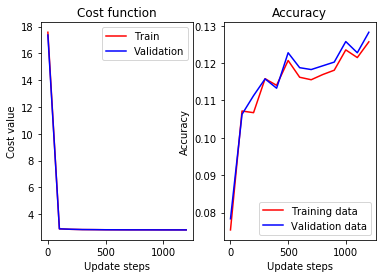

Starting state 
    Training cost: 17.575977081084446
    Training accuracy: 0.07536296132106839
    Validation cost: 17.370027940791765
    Validation accuracy: 0.0783433133732535















  0%|                                                  | 0/100 [00:00<?, ?it/s]












  1%|▍                                         | 1/100 [00:16<27:29, 16.67s/it]












  2%|▊                                         | 2/100 [00:33<27:05, 16.58s/it]












  3%|█▎                                        | 3/100 [00:49<26:46, 16.56s/it]












  4%|█▋                                        | 4/100 [01:06<26:34, 16.61s/it]












  5%|██                                        | 5/100 [01:22<26:15, 16.58s/it]












  6%|██▌                                       | 6/100 [01:39<25:56, 16.56s/it]












  7%|██▉                                       | 7/100 [01:55<25:38, 16.55s/it]












  8%|███▎                                      | 8/100 [02:12<25:21, 16.54s/it]

Iteration 8
    Training cost: 2.8926325783953852
    Training accuracy: 0.09575529203147512
    Validation cost: 2.8895057023542376
    Validation accuracy: 0.09530938123752496















  9%|███▌                                    | 9/100 [06:20<1:04:08, 42.29s/it]












 10%|████                                     | 10/100 [06:37<59:33, 39.70s/it]












 11%|████▌                                    | 11/100 [06:53<55:45, 37.59s/it]












 12%|████▉                                    | 12/100 [07:09<52:32, 35.83s/it]












 13%|█████▎                                   | 13/100 [07:26<49:47, 34.34s/it]












 14%|█████▋                                   | 14/100 [07:42<47:23, 33.06s/it]












 15%|██████▏                                  | 15/100 [07:59<45:16, 31.95s/it]












 16%|██████▌                                  | 16/100 [08:15<43:22, 30.98s/it]

Iteration 16
    Training cost: 2.8933534869944433
    Training accuracy: 0.09558905020503158
    Validation cost: 2.8900023586193417
    Validation accuracy: 0.09530938123752496















 17%|██████▋                                | 17/100 [12:23<1:00:31, 43.76s/it]












 18%|███████▍                                 | 18/100 [12:39<57:41, 42.21s/it]












 19%|███████▊                                 | 19/100 [12:55<55:07, 40.84s/it]












 20%|████████▏                                | 20/100 [13:12<52:48, 39.61s/it]












 21%|████████▌                                | 21/100 [13:28<50:41, 38.51s/it]












 22%|█████████                                | 22/100 [13:44<48:44, 37.50s/it]












 23%|█████████▍                               | 23/100 [14:01<46:56, 36.58s/it]












 24%|█████████▊                               | 24/100 [14:17<45:16, 35.75s/it]

Iteration 24
    Training cost: 2.893621207303207
    Training accuracy: 0.09558905020503158
    Validation cost: 2.8912469850913616
    Validation accuracy: 0.09530938123752496















 25%|██████████▎                              | 25/100 [14:35<43:45, 35.00s/it]












 26%|██████████▋                              | 26/100 [14:51<42:17, 34.29s/it]












 27%|███████████                              | 27/100 [15:07<40:54, 33.63s/it]












 28%|███████████▍                             | 28/100 [15:24<39:37, 33.02s/it]












 29%|███████████▉                             | 29/100 [15:41<38:23, 32.45s/it]












 30%|████████████▎                            | 30/100 [15:57<37:13, 31.91s/it]












 31%|████████████▋                            | 31/100 [16:14<36:08, 31.42s/it]












 32%|█████████████                            | 32/100 [16:30<35:05, 30.96s/it]












 33%|█████████████▌                           | 33/100 [16:47<34:04, 30.52s/it]

Iteration 33
    Training cost: 2.89609652294427
    Training accuracy: 0.09564446414717943
    Validation cost: 2.8931419934001945
    Validation accuracy: 0.09530938123752496















 34%|█████████████▉                           | 34/100 [20:57<40:40, 36.97s/it]












 35%|██████████████▎                          | 35/100 [21:13<39:25, 36.39s/it]












 36%|██████████████▊                          | 36/100 [21:30<38:13, 35.84s/it]












 37%|███████████████▏                         | 37/100 [21:46<37:04, 35.31s/it]












 38%|███████████████▌                         | 38/100 [22:03<35:58, 34.82s/it]












 39%|███████████████▉                         | 39/100 [22:19<34:55, 34.35s/it]












 40%|████████████████▍                        | 40/100 [22:36<33:54, 33.90s/it]












 41%|████████████████▊                        | 41/100 [22:52<32:55, 33.48s/it]

Iteration 41
    Training cost: 2.89421341163554
    Training accuracy: 0.09581070597362297
    Validation cost: 2.892906004388963
    Validation accuracy: 0.09281437125748503















 42%|█████████████████▏                       | 42/100 [27:01<37:19, 38.60s/it]












 43%|█████████████████▋                       | 43/100 [27:17<36:11, 38.09s/it]












 44%|██████████████████                       | 44/100 [27:34<35:05, 37.60s/it]












 45%|██████████████████▍                      | 45/100 [27:51<34:02, 37.13s/it]












 46%|██████████████████▊                      | 46/100 [28:07<33:01, 36.69s/it]












 47%|███████████████████▎                     | 47/100 [28:24<32:01, 36.26s/it]












 48%|███████████████████▋                     | 48/100 [28:40<31:03, 35.85s/it]












 49%|████████████████████                     | 49/100 [28:57<30:07, 35.45s/it]

Iteration 49
    Training cost: 2.894574587997675
    Training accuracy: 0.0958661199157708
    Validation cost: 2.892866525196415
    Validation accuracy: 0.09281437125748503















 50%|████████████████████▌                    | 50/100 [29:14<29:14, 35.09s/it]












 51%|████████████████████▉                    | 51/100 [29:31<28:22, 34.74s/it]












 52%|█████████████████████▎                   | 52/100 [29:48<27:30, 34.39s/it]












 53%|█████████████████████▋                   | 53/100 [30:04<26:40, 34.05s/it]












 54%|██████████████████████▏                  | 54/100 [30:21<25:51, 33.72s/it]












 55%|██████████████████████▌                  | 55/100 [30:37<25:03, 33.41s/it]












 56%|██████████████████████▉                  | 56/100 [30:53<24:16, 33.11s/it]












 57%|███████████████████████▎                 | 57/100 [31:10<23:31, 32.82s/it]












 58%|███████████████████████▊                 | 58/100 [31:27<22:46, 32.53s/it]

Iteration 58
    Training cost: 2.895253923477385
    Training accuracy: 0.09581070597362297
    Validation cost: 2.892609883100939
    Validation accuracy: 0.09530938123752496















 59%|████████████████████████▏                | 59/100 [35:35<24:44, 36.20s/it]












 60%|████████████████████████▌                | 60/100 [35:52<23:54, 35.87s/it]












 61%|█████████████████████████                | 61/100 [36:09<23:06, 35.56s/it]












 62%|█████████████████████████▍               | 62/100 [36:25<22:19, 35.25s/it]












 63%|█████████████████████████▊               | 63/100 [36:42<21:33, 34.96s/it]












 64%|██████████████████████████▏              | 64/100 [36:59<20:48, 34.67s/it]












 65%|██████████████████████████▋              | 65/100 [37:15<20:03, 34.40s/it]












 66%|███████████████████████████              | 66/100 [37:32<19:20, 34.13s/it]

Iteration 66
    Training cost: 2.8954882745104955
    Training accuracy: 0.09603236174221434
    Validation cost: 2.8925789200699508
    Validation accuracy: 0.09530938123752496















 67%|███████████████████████████▍             | 67/100 [41:43<20:33, 37.37s/it]












 68%|███████████████████████████▉             | 68/100 [42:00<19:45, 37.06s/it]












 69%|████████████████████████████▎            | 69/100 [42:16<18:59, 36.77s/it]












 70%|████████████████████████████▋            | 70/100 [42:33<18:14, 36.48s/it]












 71%|█████████████████████████████            | 71/100 [42:49<17:29, 36.20s/it]












 72%|█████████████████████████████▌           | 72/100 [43:06<16:45, 35.93s/it]












 73%|█████████████████████████████▉           | 73/100 [43:23<16:02, 35.66s/it]












 74%|██████████████████████████████▎          | 74/100 [43:39<15:20, 35.40s/it]

Iteration 74
    Training cost: 2.8962233629095624
    Training accuracy: 0.09625401751080571
    Validation cost: 2.893288049126174
    Validation accuracy: 0.09331337325349301















 75%|██████████████████████████████▊          | 75/100 [43:56<14:38, 35.16s/it]












 76%|███████████████████████████████▏         | 76/100 [44:13<13:57, 34.91s/it]












 77%|███████████████████████████████▌         | 77/100 [44:29<13:17, 34.67s/it]












 78%|███████████████████████████████▉         | 78/100 [44:46<12:37, 34.44s/it]












 79%|████████████████████████████████▍        | 79/100 [45:02<11:58, 34.21s/it]












 80%|████████████████████████████████▊        | 80/100 [45:19<11:19, 33.99s/it]












 81%|█████████████████████████████████▏       | 81/100 [45:35<10:41, 33.78s/it]












 82%|█████████████████████████████████▌       | 82/100 [45:52<10:04, 33.57s/it]












 83%|██████████████████████████████████       | 83/100 [46:09<09:27, 33.36s/it]

Iteration 83
    Training cost: 2.8935512553492755
    Training accuracy: 0.09592153385791866
    Validation cost: 2.8916117329400013
    Validation accuracy: 0.09481037924151696















 84%|██████████████████████████████████▍      | 84/100 [50:18<09:35, 35.94s/it]












 85%|██████████████████████████████████▊      | 85/100 [50:35<08:55, 35.71s/it]












 86%|███████████████████████████████████▎     | 86/100 [50:51<08:16, 35.49s/it]












 87%|███████████████████████████████████▋     | 87/100 [51:08<07:38, 35.27s/it]












 88%|████████████████████████████████████     | 88/100 [51:24<07:00, 35.06s/it]












 89%|████████████████████████████████████▍    | 89/100 [51:41<06:23, 34.85s/it]












 90%|████████████████████████████████████▉    | 90/100 [51:57<05:46, 34.64s/it]












 91%|█████████████████████████████████████▎   | 91/100 [52:14<05:09, 34.44s/it]

Iteration 91
    Training cost: 2.8935231471669183
    Training accuracy: 0.09592153385791866
    Validation cost: 2.89138788063115
    Validation accuracy: 0.09481037924151696















 92%|█████████████████████████████████████▋   | 92/100 [56:19<04:53, 36.74s/it]












 93%|██████████████████████████████████████▏  | 93/100 [56:35<04:15, 36.51s/it]












 94%|██████████████████████████████████████▌  | 94/100 [56:51<03:37, 36.30s/it]












 95%|██████████████████████████████████████▉  | 95/100 [57:07<03:00, 36.08s/it]












 96%|███████████████████████████████████████▎ | 96/100 [57:24<02:23, 35.88s/it]












 97%|███████████████████████████████████████▊ | 97/100 [57:40<01:47, 35.67s/it]












 98%|████████████████████████████████████████▏| 98/100 [57:56<01:10, 35.47s/it]












 99%|████████████████████████████████████████▌| 99/100 [58:12<00:35, 35.28s/it]

Iteration 99
    Training cost: 2.894702855330404
    Training accuracy: 0.09597694780006649
    Validation cost: 2.891940707142524
    Validation accuracy: 0.09530938123752496















100%|████████████████████████████████████████| 100/100 [58:29<00:00, 35.10s/it]














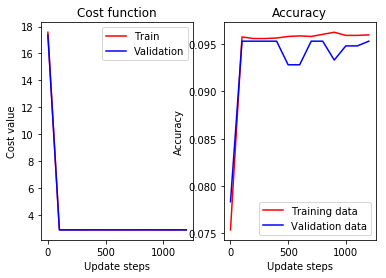

Starting state 
    Training cost: 17.575977081084446
    Training accuracy: 0.07536296132106839
    Validation cost: 17.370027940791765
    Validation accuracy: 0.0783433133732535















  0%|                                                  | 0/100 [00:00<?, ?it/s]












  1%|▍                                         | 1/100 [00:16<26:31, 16.07s/it]












  2%|▊                                         | 2/100 [00:32<26:17, 16.09s/it]












  3%|█▎                                        | 3/100 [00:48<25:58, 16.06s/it]












  4%|█▋                                        | 4/100 [01:04<25:44, 16.09s/it]












  5%|██                                        | 5/100 [01:20<25:28, 16.09s/it]












  6%|██▌                                       | 6/100 [01:36<25:11, 16.08s/it]












  7%|██▉                                       | 7/100 [01:52<24:54, 16.07s/it]












  8%|███▎                                      | 8/100 [02:08<24:39, 16.09s/it]

Iteration 8
    Training cost: 2.891994635685263
    Training accuracy: 0.09553363626288375
    Validation cost: 2.8883986802689514
    Validation accuracy: 0.09530938123752496















  9%|███▌                                    | 9/100 [06:10<1:02:30, 41.21s/it]












 10%|████                                     | 10/100 [06:26<58:02, 38.69s/it]












 11%|████▌                                    | 11/100 [06:43<54:20, 36.64s/it]












 12%|████▉                                    | 12/100 [06:59<51:13, 34.92s/it]












 13%|█████▎                                   | 13/100 [07:15<48:31, 33.47s/it]












 14%|█████▋                                   | 14/100 [07:31<46:11, 32.23s/it]












 15%|██████▏                                  | 15/100 [07:47<44:08, 31.16s/it]












 16%|██████▌                                  | 16/100 [08:03<42:18, 30.22s/it]

Iteration 16
    Training cost: 2.8941089723170674
    Training accuracy: 0.09553363626288375
    Validation cost: 2.8892710090247475
    Validation accuracy: 0.09530938123752496















 17%|██████▉                                  | 17/100 [12:06<59:07, 42.74s/it]












 18%|███████▍                                 | 18/100 [12:22<56:23, 41.26s/it]












 19%|███████▊                                 | 19/100 [12:38<53:54, 39.94s/it]












 20%|████████▏                                | 20/100 [12:54<51:39, 38.75s/it]












 21%|████████▌                                | 21/100 [13:11<49:36, 37.67s/it]












 22%|█████████                                | 22/100 [13:27<47:41, 36.69s/it]












 23%|█████████▍                               | 23/100 [13:43<45:56, 35.80s/it]












 24%|█████████▊                               | 24/100 [13:59<44:18, 34.98s/it]

Iteration 24
    Training cost: 2.8919166219551564
    Training accuracy: 0.09553363626288375
    Validation cost: 2.8891438277295025
    Validation accuracy: 0.09530938123752496















 25%|██████████▎                              | 25/100 [14:16<42:49, 34.26s/it]












 26%|██████████▋                              | 26/100 [14:32<41:23, 33.56s/it]












 27%|███████████                              | 27/100 [14:48<40:03, 32.92s/it]












 28%|███████████▍                             | 28/100 [15:04<38:47, 32.32s/it]












 29%|███████████▉                             | 29/100 [15:21<37:35, 31.76s/it]












 30%|████████████▎                            | 30/100 [15:37<36:26, 31.24s/it]












 31%|████████████▋                            | 31/100 [15:53<35:21, 30.75s/it]












 32%|█████████████                            | 32/100 [16:09<34:20, 30.30s/it]












 33%|█████████████▌                           | 33/100 [16:26<33:22, 29.89s/it]

Iteration 33
    Training cost: 2.8936744003317174
    Training accuracy: 0.09525656655214453
    Validation cost: 2.8898243842220808
    Validation accuracy: 0.09481037924151696


KeyboardInterrupt: 

In [61]:
# Tune the learning rate hyperparameter
etas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.15]
for eta in etas:
    rho = 0.9
    epochs = 100
    mini_batch_size = 100
    decay_rate = 0.99
    n_update = 100
    
    np.random.seed(100)
    filter_width_constants = [5, 3]
    filter_numbers = [20, 20]
    K = len(class_dictionary)
    conv_net = ConvNet(n = filter_numbers , k = filter_width_constants, output_dim = K, \
                       input_dim = d, nlen = max_length, he_init = True)

    GDparams = Params(mini_batch_size, eta, epochs, decay_rate, rho)
    results = conv_net.miniBatchGD(X_tr, Y_tr, GDparams, verbose = True, X_val = X_val, Y_val = Y_val, tol = 1e-10, n_update = n_update, patience = 600, imbalanced_set = True)
    makePlots(results[0], results[1], results[2], results[3], n_update)

In [ ]:
eta = 0.001
rho = 0.9
epochs = 2000
mini_batch_size = 100
decay_rate = 0.99
n_update = 100

np.random.seed(100)
filter_width_constants = [5, 3]
filter_numbers = [20, 20]
K = len(class_dictionary)
conv_net = ConvNet(n = filter_numbers , k = filter_width_constants, output_dim = K, \
                   input_dim = d, nlen = max_length, he_init = True)

GDparams = Params(mini_batch_size, eta, epochs, decay_rate, rho)
results = conv_net.miniBatchGD(X_tr, Y_tr, GDparams, verbose = True, X_val = X_val, Y_val = Y_val, tol = 1e-10,\
                               n_update = n_update, patience = 600, imbalanced_set = True)
makePlots(results[0], results[1], results[2], results[3], n_update)
plot_confusion_matrix(conv_net, inv_class_dictionary, Y_val, X_val)
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

Starting state 
    Training cost: 17.575977081084446
    Training accuracy: 0.07536296132106839
    Validation cost: 17.370027940791765
    Validation accuracy: 0.0783433133732535


















  0%|                                                 | 0/2000 [00:00<?, ?it/s]D:\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
















  0%|                                       | 1/2000 [00:16<9:09:13, 16.49s/it]















  0%|                                       | 2/2000 [00:33<9:21:42, 16.87s/it]















  0%|                                       | 3/2000 [00:50<9:24:35, 16.96s/it]















  0%|                                       | 4/2000 [01:06<9:15:22, 16.69s/it]















  0%|                                       | 5/2000 [01:22<9:08:43, 16.50s/it]















  0%|                                       | 6/2000 [01:39<9:08:28, 16.50s/it]















  0%|▏                                      | 7/2000 [01:54<9:04:55, 16.41s/it]















  0%|▏                            

Iteration 8
    Training cost: 2.9021147074245657
    Training accuracy: 0.10717056411393107
    Validation cost: 2.909000678749181
    Validation accuracy: 0.1062874251497006


















  0%|▏                                     | 9/2000 [06:15<23:02:51, 41.67s/it]















  0%|▏                                    | 10/2000 [06:31<21:37:16, 39.11s/it]















  1%|▏                                    | 11/2000 [06:47<20:27:07, 37.02s/it]















  1%|▏                                    | 12/2000 [07:02<19:27:51, 35.25s/it]















  1%|▏                                    | 13/2000 [07:18<18:36:28, 33.71s/it]















  1%|▎                                    | 14/2000 [07:34<17:55:44, 32.50s/it]















  1%|▎                                    | 15/2000 [07:51<17:19:12, 31.41s/it]















  1%|▎                                    | 16/2000 [08:06<16:45:48, 30.42s/it]

Iteration 16
    Training cost: 2.871383427954415
    Training accuracy: 0.10672725257674831
    Validation cost: 2.8751692691264594
    Validation accuracy: 0.11127744510978044


















  1%|▎                                    | 17/2000 [12:09<23:37:47, 42.90s/it]















  1%|▎                                    | 18/2000 [12:26<22:50:28, 41.49s/it]















  1%|▎                                    | 19/2000 [12:44<22:08:01, 40.22s/it]















  1%|▎                                    | 20/2000 [13:02<21:30:54, 39.12s/it]















  1%|▍                                    | 21/2000 [13:20<20:56:36, 38.10s/it]















  1%|▍                                    | 22/2000 [13:37<20:24:54, 37.16s/it]















  1%|▍                                    | 23/2000 [13:54<19:55:58, 36.30s/it]















  1%|▍                                    | 24/2000 [14:12<19:29:24, 35.51s/it]

Iteration 24
    Training cost: 2.852473897735422
    Training accuracy: 0.1158151390889948
    Validation cost: 2.8538133184278816
    Validation accuracy: 0.1157684630738523


















  1%|▍                                    | 25/2000 [14:30<19:06:04, 34.82s/it]















  1%|▍                                    | 26/2000 [14:48<18:44:04, 34.17s/it]















  1%|▍                                    | 27/2000 [15:05<18:23:22, 33.55s/it]















  1%|▌                                    | 28/2000 [15:23<18:04:05, 32.98s/it]















  1%|▌                                    | 29/2000 [15:40<17:45:51, 32.45s/it]















  2%|▌                                    | 30/2000 [15:58<17:28:49, 31.94s/it]















  2%|▌                                    | 31/2000 [16:15<17:12:53, 31.47s/it]















  2%|▌                                    | 32/2000 [16:33<16:58:43, 31.06s/it]















  2%|▌                                    | 33/2000 [16:51<16:44:48, 30.65s/it]

Iteration 33
    Training cost: 2.8481101765864683
    Training accuracy: 0.11404189294026378
    Validation cost: 2.8475243077889267
    Validation accuracy: 0.11327345309381237


















  2%|▋                                    | 34/2000 [21:06<20:20:53, 37.26s/it]















  2%|▋                                    | 35/2000 [21:24<20:01:34, 36.69s/it]















  2%|▋                                    | 36/2000 [21:41<19:43:20, 36.15s/it]















  2%|▋                                    | 37/2000 [21:58<19:26:01, 35.64s/it]















  2%|▋                                    | 38/2000 [22:15<19:09:38, 35.16s/it]















  2%|▋                                    | 39/2000 [22:33<18:54:12, 34.70s/it]















  2%|▋                                    | 40/2000 [22:50<18:39:22, 34.27s/it]















  2%|▊                                    | 41/2000 [23:07<18:25:16, 33.85s/it]

Iteration 41
    Training cost: 2.839999595155494
    Training accuracy: 0.1206915659980051
    Validation cost: 2.838757299248867
    Validation accuracy: 0.12275449101796407


















  2%|▊                                    | 42/2000 [27:26<21:19:02, 39.19s/it]















  2%|▊                                    | 43/2000 [27:43<21:01:49, 38.69s/it]















  2%|▊                                    | 44/2000 [28:00<20:45:18, 38.20s/it]















  2%|▊                                    | 45/2000 [28:18<20:29:32, 37.74s/it]















  2%|▊                                    | 46/2000 [28:35<20:14:22, 37.29s/it]















  2%|▊                                    | 47/2000 [28:52<19:59:52, 36.86s/it]















  2%|▉                                    | 48/2000 [29:09<19:45:56, 36.45s/it]















  2%|▉                                    | 49/2000 [29:27<19:32:41, 36.06s/it]

Iteration 49
    Training cost: 2.837295586204019
    Training accuracy: 0.1162030366840297
    Validation cost: 2.8353586496431373
    Validation accuracy: 0.1187624750499002


















  2%|▉                                    | 50/2000 [29:45<19:20:26, 35.71s/it]















  3%|▉                                    | 51/2000 [30:02<19:08:05, 35.34s/it]















  3%|▉                                    | 52/2000 [30:20<18:56:20, 35.00s/it]















  3%|▉                                    | 53/2000 [30:37<18:44:57, 34.67s/it]















  3%|▉                                    | 54/2000 [30:54<18:34:00, 34.35s/it]















  3%|█                                    | 55/2000 [31:12<18:23:30, 34.04s/it]















  3%|█                                    | 56/2000 [31:29<18:13:17, 33.74s/it]















  3%|█                                    | 57/2000 [31:46<18:03:22, 33.45s/it]















  3%|█                                    | 58/2000 [32:04<17:53:47, 33.18s/it]

Iteration 58
    Training cost: 2.835273648427428
    Training accuracy: 0.11553806937825557
    Validation cost: 2.832566288616954
    Validation accuracy: 0.11826347305389222


















  3%|█                                    | 59/2000 [36:24<19:57:33, 37.02s/it]















  3%|█                                    | 60/2000 [36:42<19:46:44, 36.70s/it]















  3%|█▏                                   | 61/2000 [36:59<19:36:06, 36.39s/it]















  3%|█▏                                   | 62/2000 [37:18<19:25:58, 36.10s/it]















  3%|█▏                                   | 63/2000 [37:35<19:15:58, 35.81s/it]















  3%|█▏                                   | 64/2000 [37:53<19:06:06, 35.52s/it]















  3%|█▏                                   | 65/2000 [38:10<18:56:35, 35.24s/it]















  3%|█▏                                   | 66/2000 [38:28<18:47:19, 34.97s/it]

Iteration 66
    Training cost: 2.8348324117066572
    Training accuracy: 0.11692341793195168
    Validation cost: 2.8315338408216735
    Validation accuracy: 0.11926147704590818


















  3%|█▏                                   | 67/2000 [42:46<20:34:16, 38.31s/it]















  3%|█▎                                   | 68/2000 [43:04<20:23:45, 38.00s/it]















  3%|█▎                                   | 69/2000 [43:21<20:13:23, 37.70s/it]















  4%|█▎                                   | 70/2000 [43:38<20:03:22, 37.41s/it]















  4%|█▎                                   | 71/2000 [43:55<19:53:32, 37.12s/it]















  4%|█▎                                   | 72/2000 [44:13<19:44:03, 36.85s/it]















  4%|█▎                                   | 73/2000 [44:30<19:34:50, 36.58s/it]















  4%|█▎                                   | 74/2000 [44:47<19:25:55, 36.32s/it]

Iteration 74
    Training cost: 2.833879824022227
    Training accuracy: 0.11808711071705641
    Validation cost: 2.830423808046022
    Validation accuracy: 0.12025948103792415


















  4%|█▍                                   | 75/2000 [45:05<19:17:32, 36.08s/it]















  4%|█▍                                   | 76/2000 [45:23<19:09:04, 35.83s/it]















  4%|█▍                                   | 77/2000 [45:40<19:00:45, 35.59s/it]















  4%|█▍                                   | 78/2000 [45:57<18:52:39, 35.36s/it]















  4%|█▍                                   | 79/2000 [46:15<18:44:44, 35.13s/it]















  4%|█▍                                   | 80/2000 [46:32<18:36:56, 34.90s/it]















  4%|█▍                                   | 81/2000 [46:49<18:29:23, 34.69s/it]















  4%|█▌                                   | 82/2000 [47:06<18:22:02, 34.47s/it]















  4%|█▌                                   | 83/2000 [47:24<18:14:49, 34.27s/it]

Iteration 83
    Training cost: 2.8318311996486956
    Training accuracy: 0.12351767704754517
    Validation cost: 2.8281670742609593
    Validation accuracy: 0.12574850299401197


















  4%|█▌                                   | 84/2000 [51:44<19:40:15, 36.96s/it]















  4%|█▌                                   | 85/2000 [52:02<19:32:18, 36.73s/it]















  4%|█▌                                   | 86/2000 [52:19<19:24:32, 36.51s/it]















  4%|█▌                                   | 87/2000 [52:37<19:16:57, 36.29s/it]















  4%|█▋                                   | 88/2000 [52:54<19:09:30, 36.07s/it]















  4%|█▋                                   | 89/2000 [53:11<19:02:10, 35.86s/it]















  4%|█▋                                   | 90/2000 [53:28<18:55:00, 35.65s/it]















  5%|█▋                                   | 91/2000 [53:46<18:48:02, 35.45s/it]

Iteration 91
    Training cost: 2.8308406885323723
    Training accuracy: 0.12146736118807493
    Validation cost: 2.827460168079876
    Validation accuracy: 0.12275449101796407


















  5%|█▋                                   | 92/2000 [58:10<20:06:19, 37.93s/it]















  5%|█▋                                   | 93/2000 [58:27<19:58:43, 37.72s/it]















  5%|█▋                                   | 94/2000 [58:45<19:51:18, 37.50s/it]















  5%|█▊                                   | 95/2000 [59:02<19:44:01, 37.29s/it]















  5%|█▊                                   | 96/2000 [59:20<19:36:54, 37.09s/it]















  5%|█▊                                   | 97/2000 [59:37<19:29:53, 36.89s/it]















  5%|█▊                                   | 98/2000 [59:55<19:23:03, 36.69s/it]















  5%|█▋                                 | 99/2000 [1:00:13<19:16:29, 36.50s/it]

Iteration 99
    Training cost: 2.8303707430433547
    Training accuracy: 0.1256788207913111
    Validation cost: 2.8267762908914342
    Validation accuracy: 0.1282435129740519


















  5%|█▋                                | 100/2000 [1:00:32<19:10:08, 36.32s/it]















  5%|█▋                                | 101/2000 [1:00:49<19:03:38, 36.13s/it]















  5%|█▋                                | 102/2000 [1:01:07<18:57:16, 35.95s/it]















  5%|█▊                                | 103/2000 [1:01:24<18:51:02, 35.77s/it]















  5%|█▊                                | 104/2000 [1:01:42<18:44:51, 35.60s/it]















  5%|█▊                                | 105/2000 [1:01:59<18:38:48, 35.42s/it]















  5%|█▊                                | 106/2000 [1:02:16<18:32:51, 35.25s/it]















  5%|█▊                                | 107/2000 [1:02:34<18:27:00, 35.09s/it]















  5%|█▊                                | 108/2000 [1:02:52<18:21:21, 34.93s/it]

Iteration 108
    Training cost: 2.831563379998939
    Training accuracy: 0.12362850493184085
    Validation cost: 2.827831581867044
    Validation accuracy: 0.12624750499001997


















  5%|█▊                                | 109/2000 [1:07:15<19:26:42, 37.02s/it]















  6%|█▊                                | 110/2000 [1:07:32<19:20:30, 36.84s/it]















  6%|█▉                                | 111/2000 [1:07:50<19:14:25, 36.67s/it]















  6%|█▉                                | 112/2000 [1:08:08<19:08:36, 36.50s/it]















  6%|█▉                                | 113/2000 [1:08:25<19:02:33, 36.33s/it]















  6%|█▉                                | 114/2000 [1:08:43<18:57:00, 36.17s/it]















  6%|█▉                                | 115/2000 [1:09:01<18:51:22, 36.01s/it]















  6%|█▉                                | 116/2000 [1:09:18<18:45:46, 35.85s/it]

Iteration 116
    Training cost: 2.8304424295754775
    Training accuracy: 0.12385016070043223
    Validation cost: 2.826746662076672
    Validation accuracy: 0.12624750499001997


















  6%|█▉                                | 117/2000 [1:13:32<19:43:27, 37.71s/it]















  6%|██                                | 118/2000 [1:13:48<19:37:11, 37.53s/it]















  6%|██                                | 119/2000 [1:14:05<19:31:04, 37.36s/it]















  6%|██                                | 120/2000 [1:14:21<19:25:00, 37.18s/it]















  6%|██                                | 121/2000 [1:14:38<19:19:08, 37.01s/it]















  6%|██                                | 122/2000 [1:14:55<19:13:23, 36.85s/it]















  6%|██                                | 123/2000 [1:15:12<19:07:37, 36.68s/it]















  6%|██                                | 124/2000 [1:15:29<19:02:06, 36.53s/it]

Iteration 124
    Training cost: 2.8308738368121515
    Training accuracy: 0.12296353762606672
    Validation cost: 2.8271932789607357
    Validation accuracy: 0.124750499001996


















  6%|██▏                               | 125/2000 [1:15:46<18:56:37, 36.37s/it]















  6%|██▏                               | 126/2000 [1:16:02<18:51:02, 36.21s/it]















  6%|██▏                               | 127/2000 [1:16:18<18:45:30, 36.05s/it]















  6%|██▏                               | 128/2000 [1:16:35<18:40:10, 35.90s/it]















  6%|██▏                               | 129/2000 [1:16:52<18:34:58, 35.76s/it]















  6%|██▏                               | 130/2000 [1:17:09<18:29:51, 35.61s/it]















  7%|██▏                               | 131/2000 [1:17:25<18:24:39, 35.46s/it]















  7%|██▏                               | 132/2000 [1:17:42<18:19:35, 35.32s/it]















  7%|██▎                               | 133/2000 [1:17:58<18:14:34, 35.18s/it]

Iteration 133
    Training cost: 2.8309751111379837
    Training accuracy: 0.12301895156821456
    Validation cost: 2.8274716530514397
    Validation accuracy: 0.124750499001996


















  7%|██▎                               | 134/2000 [1:21:57<19:01:23, 36.70s/it]















  7%|██▎                               | 135/2000 [1:22:14<18:56:03, 36.55s/it]















  7%|██▎                               | 136/2000 [1:22:30<18:50:46, 36.40s/it]















  7%|██▎                               | 137/2000 [1:22:46<18:45:34, 36.25s/it]















  7%|██▎                               | 138/2000 [1:23:02<18:40:28, 36.11s/it]















  7%|██▎                               | 139/2000 [1:23:18<18:35:28, 35.96s/it]















  7%|██▍                               | 140/2000 [1:23:35<18:30:33, 35.82s/it]















  7%|██▍                               | 141/2000 [1:23:51<18:25:41, 35.69s/it]

Iteration 141
    Training cost: 2.830225531390566
    Training accuracy: 0.12263105397317965
    Validation cost: 2.827026675995376
    Validation accuracy: 0.125249500998004


















  7%|██▍                               | 142/2000 [1:27:52<19:09:54, 37.13s/it]















  7%|██▍                               | 143/2000 [1:28:09<19:04:45, 36.99s/it]















  7%|██▍                               | 144/2000 [1:28:25<18:59:45, 36.85s/it]















  7%|██▍                               | 145/2000 [1:28:41<18:54:42, 36.70s/it]















  7%|██▍                               | 146/2000 [1:28:58<18:49:46, 36.56s/it]















  7%|██▍                               | 147/2000 [1:29:14<18:44:50, 36.42s/it]















  7%|██▌                               | 148/2000 [1:29:30<18:39:59, 36.28s/it]















  7%|██▌                               | 149/2000 [1:29:46<18:35:13, 36.15s/it]

Iteration 149
    Training cost: 2.830735734793534
    Training accuracy: 0.12285270974177102
    Validation cost: 2.827355899008323
    Validation accuracy: 0.12425149700598802


















  8%|██▌                               | 150/2000 [1:30:03<18:30:39, 36.02s/it]















  8%|██▌                               | 151/2000 [1:30:19<18:26:00, 35.89s/it]















  8%|██▌                               | 152/2000 [1:30:35<18:21:25, 35.76s/it]















  8%|██▌                               | 153/2000 [1:30:51<18:16:52, 35.63s/it]















  8%|██▌                               | 154/2000 [1:31:08<18:12:25, 35.51s/it]















  8%|██▋                               | 155/2000 [1:31:24<18:07:58, 35.38s/it]















  8%|██▋                               | 156/2000 [1:31:40<18:03:33, 35.26s/it]















  8%|██▋                               | 157/2000 [1:31:56<17:59:14, 35.14s/it]















  8%|██▋                               | 158/2000 [1:32:12<17:54:58, 35.02s/it]

Iteration 158
    Training cost: 2.830588311875808
    Training accuracy: 0.12113487753518785
    Validation cost: 2.827196025595693
    Validation accuracy: 0.12325349301397205


















  8%|██▋                               | 159/2000 [1:36:10<18:33:38, 36.29s/it]















  8%|██▋                               | 160/2000 [1:36:27<18:29:14, 36.17s/it]















  8%|██▋                               | 161/2000 [1:36:43<18:24:49, 36.05s/it]















  8%|██▊                               | 162/2000 [1:36:59<18:20:25, 35.92s/it]















  8%|██▊                               | 163/2000 [1:37:15<18:16:05, 35.80s/it]















  8%|██▊                               | 164/2000 [1:37:31<18:11:48, 35.68s/it]















  8%|██▊                               | 165/2000 [1:37:47<18:07:35, 35.56s/it]















  8%|██▊                               | 166/2000 [1:38:03<18:03:23, 35.44s/it]

Iteration 166
    Training cost: 2.830258478565029
    Training accuracy: 0.12274188185747534
    Validation cost: 2.8269857980358424
    Validation accuracy: 0.12425149700598802


















  8%|██▊                               | 167/2000 [1:42:04<18:40:18, 36.67s/it]















  8%|██▊                               | 168/2000 [1:42:20<18:35:57, 36.55s/it]















  8%|██▊                               | 169/2000 [1:42:36<18:31:39, 36.43s/it]















  8%|██▉                               | 170/2000 [1:42:52<18:27:23, 36.31s/it]















  9%|██▉                               | 171/2000 [1:43:08<18:23:11, 36.19s/it]















  9%|██▉                               | 172/2000 [1:43:24<18:19:01, 36.07s/it]















  9%|██▉                               | 173/2000 [1:43:40<18:14:57, 35.96s/it]















  9%|██▉                               | 174/2000 [1:43:57<18:10:52, 35.84s/it]

Iteration 174
    Training cost: 2.8300545402335406
    Training accuracy: 0.12379474675828439
    Validation cost: 2.826943621357349
    Validation accuracy: 0.12624750499001997


















  9%|██▉                               | 175/2000 [1:44:13<18:06:58, 35.74s/it]















  9%|██▉                               | 176/2000 [1:44:30<18:03:03, 35.63s/it]















  9%|███                               | 177/2000 [1:44:46<17:59:07, 35.52s/it]















  9%|███                               | 178/2000 [1:45:02<17:55:13, 35.41s/it]















  9%|███                               | 179/2000 [1:45:18<17:51:21, 35.30s/it]















  9%|███                               | 180/2000 [1:45:34<17:47:32, 35.19s/it]















  9%|███                               | 181/2000 [1:45:50<17:43:44, 35.09s/it]















  9%|███                               | 182/2000 [1:46:07<17:40:00, 34.98s/it]















  9%|███                               | 183/2000 [1:46:23<17:36:17, 34.88s/it]

Iteration 183
    Training cost: 2.8305970793227515
    Training accuracy: 0.12307436551036241
    Validation cost: 2.8275365816245634
    Validation accuracy: 0.124750499001996


















  9%|███▏                              | 184/2000 [1:50:24<18:09:44, 36.00s/it]















  9%|███▏                              | 185/2000 [1:50:40<18:05:53, 35.90s/it]















  9%|███▏                              | 186/2000 [1:50:57<18:02:09, 35.79s/it]















  9%|███▏                              | 187/2000 [1:51:13<17:58:22, 35.69s/it]















  9%|███▏                              | 188/2000 [1:51:29<17:54:39, 35.58s/it]















  9%|███▏                              | 189/2000 [1:51:46<17:50:57, 35.48s/it]















 10%|███▏                              | 190/2000 [1:52:02<17:47:20, 35.38s/it]















 10%|███▏                              | 191/2000 [1:52:18<17:43:44, 35.28s/it]

Iteration 191
    Training cost: 2.8298311102788256
    Training accuracy: 0.12440430012191067
    Validation cost: 2.8270936895930117
    Validation accuracy: 0.12674650698602793


















 10%|███▎                              | 192/2000 [1:56:24<18:16:14, 36.38s/it]















 10%|███▎                              | 193/2000 [1:56:41<18:12:33, 36.28s/it]















 10%|███▎                              | 194/2000 [1:56:57<18:08:50, 36.17s/it]















 10%|███▎                              | 195/2000 [1:57:14<18:05:11, 36.07s/it]















 10%|███▎                              | 196/2000 [1:57:30<18:01:32, 35.97s/it]















 10%|███▎                              | 197/2000 [1:57:46<17:57:54, 35.87s/it]















 10%|███▎                              | 198/2000 [1:58:03<17:54:23, 35.77s/it]















 10%|███▍                              | 199/2000 [1:58:19<17:50:49, 35.67s/it]

Iteration 199
    Training cost: 2.8297094964751897
    Training accuracy: 0.12612213232849384
    Validation cost: 2.8270265073438208
    Validation accuracy: 0.1277445109780439


















 10%|███▍                              | 200/2000 [1:58:36<17:47:28, 35.58s/it]















 10%|███▍                              | 201/2000 [1:58:52<17:43:59, 35.49s/it]















 10%|███▍                              | 202/2000 [1:59:08<17:40:31, 35.39s/it]















 10%|███▍                              | 203/2000 [1:59:24<17:37:05, 35.29s/it]















 10%|███▍                              | 204/2000 [1:59:41<17:33:42, 35.20s/it]















 10%|███▍                              | 205/2000 [1:59:57<17:30:21, 35.11s/it]















 10%|███▌                              | 206/2000 [2:00:13<17:27:00, 35.02s/it]















 10%|███▌                              | 207/2000 [2:00:29<17:23:41, 34.93s/it]















 10%|███▌                              | 208/2000 [2:00:45<17:20:24, 34.84s/it]

Iteration 208
    Training cost: 2.829921855987881
    Training accuracy: 0.12312977945251025
    Validation cost: 2.82728030877877
    Validation accuracy: 0.12425149700598802


















 10%|███▌                              | 209/2000 [2:04:50<17:49:45, 35.84s/it]















 10%|███▌                              | 210/2000 [2:05:06<17:46:23, 35.74s/it]















 11%|███▌                              | 211/2000 [2:05:23<17:43:11, 35.66s/it]















 11%|███▌                              | 212/2000 [2:05:40<17:39:59, 35.57s/it]















 11%|███▌                              | 213/2000 [2:05:57<17:36:47, 35.48s/it]















 11%|███▋                              | 214/2000 [2:06:14<17:33:33, 35.39s/it]















 11%|███▋                              | 215/2000 [2:06:30<17:30:16, 35.30s/it]















 11%|███▋                              | 216/2000 [2:06:45<17:26:53, 35.21s/it]

Iteration 216
    Training cost: 2.8294592195432675
    Training accuracy: 0.12573423473345893
    Validation cost: 2.8269073763057504
    Validation accuracy: 0.1277445109780439


















 11%|███▋                              | 217/2000 [2:10:53<17:55:26, 36.19s/it]















 11%|███▋                              | 218/2000 [2:11:08<17:51:57, 36.09s/it]















 11%|███▋                              | 219/2000 [2:11:23<17:48:27, 36.00s/it]















 11%|███▋                              | 220/2000 [2:11:38<17:45:02, 35.90s/it]















 11%|███▊                              | 221/2000 [2:11:53<17:41:41, 35.81s/it]















 11%|███▊                              | 222/2000 [2:12:08<17:38:16, 35.71s/it]















 11%|███▊                              | 223/2000 [2:12:23<17:34:54, 35.62s/it]















 11%|███▊                              | 224/2000 [2:12:37<17:31:34, 35.53s/it]

Iteration 224
    Training cost: 2.82948419208226
    Training accuracy: 0.12445971406405852
    Validation cost: 2.82713480083109
    Validation accuracy: 0.12574850299401197


















 11%|███▊                              | 225/2000 [2:12:53<17:28:25, 35.44s/it]















 11%|███▊                              | 226/2000 [2:13:08<17:25:09, 35.35s/it]















 11%|███▊                              | 227/2000 [2:13:23<17:21:54, 35.26s/it]















 11%|███▉                              | 228/2000 [2:13:39<17:18:43, 35.17s/it]















 11%|███▉                              | 229/2000 [2:13:54<17:15:32, 35.08s/it]















 12%|███▉                              | 230/2000 [2:14:08<17:12:22, 35.00s/it]















 12%|███▉                              | 231/2000 [2:14:23<17:09:11, 34.91s/it]















 12%|███▉                              | 232/2000 [2:14:38<17:06:06, 34.82s/it]















 12%|███▉                              | 233/2000 [2:14:54<17:03:03, 34.74s/it]

Iteration 233
    Training cost: 2.8295789817791346
    Training accuracy: 0.12401640252687576
    Validation cost: 2.8272367190765033
    Validation accuracy: 0.12674650698602793


















 12%|███▉                              | 234/2000 [2:18:37<17:26:15, 35.55s/it]















 12%|███▉                              | 235/2000 [2:18:52<17:23:04, 35.46s/it]















 12%|████                              | 236/2000 [2:19:07<17:19:56, 35.37s/it]















 12%|████                              | 237/2000 [2:19:22<17:16:48, 35.29s/it]















 12%|████                              | 238/2000 [2:19:37<17:13:41, 35.20s/it]















 12%|████                              | 239/2000 [2:19:52<17:10:38, 35.12s/it]















 12%|████                              | 240/2000 [2:20:07<17:07:36, 35.03s/it]















 12%|████                              | 241/2000 [2:20:22<17:04:35, 34.95s/it]

Iteration 241
    Training cost: 2.8298389397191444
    Training accuracy: 0.12584506261775463
    Validation cost: 2.8273908156810386
    Validation accuracy: 0.1282435129740519


















 12%|████                              | 242/2000 [2:24:15<17:27:54, 35.76s/it]















 12%|████▏                             | 243/2000 [2:24:30<17:24:54, 35.68s/it]















 12%|████▏                             | 244/2000 [2:24:46<17:21:54, 35.60s/it]















 12%|████▏                             | 245/2000 [2:25:02<17:18:55, 35.52s/it]















 12%|████▏                             | 246/2000 [2:25:17<17:15:57, 35.44s/it]















 12%|████▏                             | 247/2000 [2:25:33<17:13:01, 35.36s/it]















 12%|████▏                             | 248/2000 [2:25:48<17:10:05, 35.28s/it]















 12%|████▏                             | 249/2000 [2:26:04<17:07:11, 35.20s/it]

Iteration 249
    Training cost: 2.829663275286226
    Training accuracy: 0.12434888617976282
    Validation cost: 2.827275083700682
    Validation accuracy: 0.12624750499001997


















 12%|████▎                             | 250/2000 [2:26:20<17:04:25, 35.12s/it]















 13%|████▎                             | 251/2000 [2:26:35<17:01:28, 35.04s/it]















 13%|████▎                             | 252/2000 [2:26:50<16:58:35, 34.96s/it]















 13%|████▎                             | 253/2000 [2:27:06<16:55:44, 34.89s/it]















 13%|████▎                             | 254/2000 [2:27:20<16:52:52, 34.81s/it]















 13%|████▎                             | 255/2000 [2:27:36<16:50:03, 34.73s/it]















 13%|████▎                             | 256/2000 [2:27:51<16:47:18, 34.66s/it]















 13%|████▎                             | 257/2000 [2:28:07<16:44:33, 34.58s/it]















 13%|████▍                             | 258/2000 [2:28:22<16:41:47, 34.51s/it]

Iteration 258
    Training cost: 2.8295174403578254
    Training accuracy: 0.12495843954338912
    Validation cost: 2.8271765294505844
    Validation accuracy: 0.12674650698602793


















 13%|████▍                             | 259/2000 [2:32:01<17:01:54, 35.22s/it]















 13%|████▍                             | 260/2000 [2:32:16<16:59:03, 35.14s/it]















 13%|████▍                             | 261/2000 [2:32:31<16:56:12, 35.06s/it]















 13%|████▍                             | 262/2000 [2:32:45<16:53:22, 34.98s/it]















 13%|████▍                             | 263/2000 [2:33:01<16:50:36, 34.91s/it]















 13%|████▍                             | 264/2000 [2:33:16<16:47:51, 34.83s/it]















 13%|████▌                             | 265/2000 [2:33:30<16:45:04, 34.76s/it]















 13%|████▌                             | 266/2000 [2:33:45<16:42:19, 34.68s/it]

Iteration 266
    Training cost: 2.8293955562061015
    Training accuracy: 0.1246813698326499
    Validation cost: 2.827128523334591
    Validation accuracy: 0.12674650698602793


















 13%|████▌                             | 267/2000 [2:37:38<17:03:08, 35.42s/it]















 13%|████▌                             | 268/2000 [2:37:53<17:00:23, 35.35s/it]















 13%|████▌                             | 269/2000 [2:38:08<16:57:38, 35.27s/it]















 14%|████▌                             | 270/2000 [2:38:24<16:54:57, 35.20s/it]















 14%|████▌                             | 271/2000 [2:38:39<16:52:13, 35.13s/it]















 14%|████▌                             | 272/2000 [2:38:54<16:49:33, 35.05s/it]















 14%|████▋                             | 273/2000 [2:39:09<16:46:52, 34.98s/it]















 14%|████▋                             | 274/2000 [2:39:25<16:44:12, 34.91s/it]

Iteration 274
    Training cost: 2.8290258007373166
    Training accuracy: 0.126066718386346
    Validation cost: 2.826727257048105
    Validation accuracy: 0.12874251497005987


















 14%|████▋                             | 275/2000 [2:39:41<16:41:40, 34.84s/it]















 14%|████▋                             | 276/2000 [2:39:56<16:39:04, 34.77s/it]















 14%|████▋                             | 277/2000 [2:40:12<16:36:29, 34.70s/it]















 14%|████▋                             | 278/2000 [2:40:27<16:33:56, 34.63s/it]















 14%|████▋                             | 279/2000 [2:40:43<16:31:23, 34.56s/it]















 14%|████▊                             | 280/2000 [2:40:58<16:28:51, 34.49s/it]















 14%|████▊                             | 281/2000 [2:41:13<16:26:19, 34.43s/it]















 14%|████▊                             | 282/2000 [2:41:29<16:23:49, 34.36s/it]















 14%|████▊                             | 283/2000 [2:41:44<16:21:20, 34.29s/it]

Iteration 283
    Training cost: 2.829072002855987
    Training accuracy: 0.126066718386346
    Validation cost: 2.8267858928491116
    Validation accuracy: 0.1282435129740519


















 14%|████▊                             | 284/2000 [2:45:39<16:40:58, 35.00s/it]















 14%|████▊                             | 285/2000 [2:45:54<16:38:21, 34.93s/it]















 14%|████▊                             | 286/2000 [2:46:09<16:35:45, 34.86s/it]















 14%|████▉                             | 287/2000 [2:46:23<16:33:09, 34.79s/it]















 14%|████▉                             | 288/2000 [2:46:38<16:30:34, 34.72s/it]















 14%|████▉                             | 289/2000 [2:46:53<16:28:02, 34.65s/it]















 14%|████▉                             | 290/2000 [2:47:07<16:25:30, 34.58s/it]















 15%|████▉                             | 291/2000 [2:47:23<16:23:01, 34.51s/it]

Iteration 291
    Training cost: 2.8287927652532767
    Training accuracy: 0.12584506261775463
    Validation cost: 2.8265813446851134
    Validation accuracy: 0.1282435129740519


















 15%|████▉                             | 292/2000 [2:51:17<16:41:54, 35.20s/it]















 15%|████▉                             | 293/2000 [2:51:32<16:39:24, 35.13s/it]















 15%|████▉                             | 294/2000 [2:51:48<16:36:56, 35.06s/it]















 15%|█████                             | 295/2000 [2:52:03<16:34:27, 35.00s/it]















 15%|█████                             | 296/2000 [2:52:19<16:31:59, 34.93s/it]















 15%|█████                             | 297/2000 [2:52:34<16:29:33, 34.86s/it]















 15%|█████                             | 298/2000 [2:52:49<16:27:06, 34.80s/it]















 15%|█████                             | 299/2000 [2:53:04<16:24:39, 34.73s/it]

Iteration 299
    Training cost: 2.828814572516441
    Training accuracy: 0.12573423473345893
    Validation cost: 2.826597547049427
    Validation accuracy: 0.1282435129740519


















 15%|█████                             | 300/2000 [2:53:20<16:22:18, 34.67s/it]















 15%|█████                             | 301/2000 [2:53:35<16:19:52, 34.60s/it]















 15%|█████▏                            | 302/2000 [2:53:51<16:17:28, 34.54s/it]















 15%|█████▏                            | 303/2000 [2:54:05<16:15:03, 34.47s/it]















 15%|█████▏                            | 304/2000 [2:54:20<16:12:40, 34.41s/it]















 15%|█████▏                            | 305/2000 [2:54:35<16:10:17, 34.35s/it]















 15%|█████▏                            | 306/2000 [2:54:50<16:07:55, 34.28s/it]















 15%|█████▏                            | 307/2000 [2:55:05<16:05:34, 34.22s/it]















 15%|█████▏                            | 308/2000 [2:55:20<16:03:13, 34.16s/it]

Iteration 308
    Training cost: 2.8288288480393518
    Training accuracy: 0.12573423473345893
    Validation cost: 2.826621585304958
    Validation accuracy: 0.1282435129740519


















 15%|█████▎                            | 309/2000 [2:59:02<16:19:50, 34.77s/it]















 16%|█████▎                            | 310/2000 [2:59:18<16:17:30, 34.70s/it]















 16%|█████▎                            | 311/2000 [2:59:33<16:15:08, 34.64s/it]















 16%|█████▎                            | 312/2000 [2:59:48<16:12:47, 34.58s/it]















 16%|█████▎                            | 313/2000 [3:00:03<16:10:26, 34.51s/it]















 16%|█████▎                            | 314/2000 [3:00:18<16:08:07, 34.45s/it]















 16%|█████▎                            | 315/2000 [3:00:33<16:05:48, 34.39s/it]















 16%|█████▎                            | 316/2000 [3:00:48<16:03:30, 34.33s/it]

Iteration 316
    Training cost: 2.828627886305175
    Training accuracy: 0.12573423473345893
    Validation cost: 2.826430334583361
    Validation accuracy: 0.1282435129740519


















 16%|█████▍                            | 317/2000 [3:04:30<16:19:37, 34.92s/it]















 16%|█████▍                            | 318/2000 [3:04:45<16:17:16, 34.86s/it]















 16%|█████▍                            | 319/2000 [3:05:00<16:14:57, 34.80s/it]















 16%|█████▍                            | 320/2000 [3:05:16<16:12:39, 34.74s/it]















 16%|█████▍                            | 321/2000 [3:05:30<16:10:20, 34.68s/it]















 16%|█████▍                            | 322/2000 [3:05:46<16:08:05, 34.62s/it]















 16%|█████▍                            | 323/2000 [3:06:01<16:05:47, 34.55s/it]















 16%|█████▌                            | 324/2000 [3:06:16<16:03:32, 34.49s/it]

Iteration 324
    Training cost: 2.8285776446061917
    Training accuracy: 0.12462595589050204
    Validation cost: 2.826402695030744
    Validation accuracy: 0.12624750499001997


















 16%|█████▌                            | 325/2000 [3:06:31<16:01:20, 34.44s/it]















 16%|█████▌                            | 326/2000 [3:06:47<15:59:08, 34.38s/it]















 16%|█████▌                            | 327/2000 [3:07:02<15:56:55, 34.32s/it]















 16%|█████▌                            | 328/2000 [3:07:17<15:54:42, 34.26s/it]















 16%|█████▌                            | 329/2000 [3:07:32<15:52:30, 34.20s/it]















 16%|█████▌                            | 330/2000 [3:07:47<15:50:20, 34.14s/it]















 17%|█████▋                            | 331/2000 [3:08:02<15:48:11, 34.09s/it]















 17%|█████▋                            | 332/2000 [3:08:18<15:46:03, 34.03s/it]















 17%|█████▋                            | 333/2000 [3:08:33<15:43:53, 33.97s/it]

Iteration 333
    Training cost: 2.8286403531171764
    Training accuracy: 0.12462595589050204
    Validation cost: 2.826454843011987
    Validation accuracy: 0.12624750499001997


















 17%|█████▋                            | 334/2000 [3:12:12<15:58:44, 34.53s/it]















 17%|█████▋                            | 335/2000 [3:12:27<15:56:33, 34.47s/it]















 17%|█████▋                            | 336/2000 [3:12:42<15:54:22, 34.41s/it]















 17%|█████▋                            | 337/2000 [3:12:57<15:52:12, 34.36s/it]















 17%|█████▋                            | 338/2000 [3:13:12<15:50:03, 34.30s/it]















 17%|█████▊                            | 339/2000 [3:13:27<15:47:55, 34.24s/it]















 17%|█████▊                            | 340/2000 [3:13:43<15:45:49, 34.19s/it]















 17%|█████▊                            | 341/2000 [3:13:58<15:43:44, 34.13s/it]

Iteration 341
    Training cost: 2.8284870089292067
    Training accuracy: 0.1246813698326499
    Validation cost: 2.82636820921281
    Validation accuracy: 0.12624750499001997


















 17%|█████▊                            | 342/2000 [3:17:51<15:59:14, 34.71s/it]















 17%|█████▊                            | 343/2000 [3:18:07<15:57:07, 34.66s/it]















 17%|█████▊                            | 344/2000 [3:18:22<15:54:58, 34.60s/it]















 17%|█████▊                            | 345/2000 [3:18:37<15:52:51, 34.54s/it]















 17%|█████▉                            | 346/2000 [3:18:53<15:50:44, 34.49s/it]















 17%|█████▉                            | 347/2000 [3:19:08<15:48:39, 34.43s/it]















 17%|█████▉                            | 348/2000 [3:19:24<15:46:35, 34.38s/it]















 17%|█████▉                            | 349/2000 [3:19:39<15:44:31, 34.33s/it]

Iteration 349
    Training cost: 2.8284466183751076
    Training accuracy: 0.12739665299789427
    Validation cost: 2.826380091742689
    Validation accuracy: 0.13023952095808383


















 18%|█████▉                            | 350/2000 [3:19:55<15:42:31, 34.27s/it]















 18%|█████▉                            | 351/2000 [3:20:10<15:40:26, 34.22s/it]















 18%|█████▉                            | 352/2000 [3:20:26<15:38:24, 34.17s/it]















 18%|██████                            | 353/2000 [3:20:41<15:36:22, 34.11s/it]















 18%|██████                            | 354/2000 [3:20:57<15:34:21, 34.06s/it]















 18%|██████                            | 355/2000 [3:21:12<15:32:22, 34.01s/it]















 18%|██████                            | 356/2000 [3:21:27<15:30:20, 33.95s/it]















 18%|██████                            | 357/2000 [3:21:43<15:28:23, 33.90s/it]















 18%|██████                            | 358/2000 [3:21:58<15:26:24, 33.85s/it]

Iteration 358
    Training cost: 2.828300134921071
    Training accuracy: 0.1246813698326499
    Validation cost: 2.8262543834814635
    Validation accuracy: 0.12624750499001997


















 18%|██████                            | 359/2000 [3:25:54<15:41:10, 34.41s/it]















 18%|██████                            | 360/2000 [3:26:09<15:39:10, 34.36s/it]















 18%|██████▏                           | 361/2000 [3:26:25<15:37:10, 34.31s/it]















 18%|██████▏                           | 362/2000 [3:26:40<15:35:09, 34.25s/it]















 18%|██████▏                           | 363/2000 [3:26:55<15:33:10, 34.20s/it]















 18%|██████▏                           | 364/2000 [3:27:11<15:31:13, 34.15s/it]















 18%|██████▏                           | 365/2000 [3:27:27<15:29:16, 34.10s/it]















 18%|██████▏                           | 366/2000 [3:27:42<15:27:20, 34.05s/it]

Iteration 366
    Training cost: 2.8282471799483604
    Training accuracy: 0.1246813698326499
    Validation cost: 2.8262083438455288
    Validation accuracy: 0.12624750499001997


















 18%|██████▏                           | 367/2000 [3:31:33<15:41:22, 34.59s/it]















 18%|██████▎                           | 368/2000 [3:31:49<15:39:24, 34.54s/it]















 18%|██████▎                           | 369/2000 [3:32:05<15:37:25, 34.49s/it]















 18%|██████▎                           | 370/2000 [3:32:20<15:35:27, 34.43s/it]















 19%|██████▎                           | 371/2000 [3:32:36<15:33:30, 34.38s/it]















 19%|██████▎                           | 372/2000 [3:32:51<15:31:32, 34.33s/it]















 19%|██████▎                           | 373/2000 [3:33:07<15:29:36, 34.28s/it]















 19%|██████▎                           | 374/2000 [3:33:22<15:27:40, 34.23s/it]

Iteration 374
    Training cost: 2.8282194777056353
    Training accuracy: 0.1246813698326499
    Validation cost: 2.8262054567731276
    Validation accuracy: 0.12624750499001997


















 19%|██████▍                           | 375/2000 [3:33:38<15:25:48, 34.18s/it]















 19%|██████▍                           | 376/2000 [3:33:54<15:23:53, 34.13s/it]















 19%|██████▍                           | 377/2000 [3:34:09<15:21:59, 34.08s/it]















 19%|██████▍                           | 378/2000 [3:34:25<15:20:04, 34.04s/it]















 19%|██████▍                           | 379/2000 [3:34:40<15:18:11, 33.99s/it]















 19%|██████▍                           | 380/2000 [3:34:56<15:16:18, 33.94s/it]















 19%|██████▍                           | 381/2000 [3:35:11<15:14:24, 33.89s/it]















 19%|██████▍                           | 382/2000 [3:35:26<15:12:30, 33.84s/it]















 19%|██████▌                           | 383/2000 [3:35:41<15:10:39, 33.79s/it]

Iteration 383
    Training cost: 2.8283033426903064
    Training accuracy: 0.12462595589050204
    Validation cost: 2.8262943913292093
    Validation accuracy: 0.12624750499001997


















 19%|██████▌                           | 384/2000 [3:39:36<15:24:12, 34.31s/it]















 19%|██████▌                           | 385/2000 [3:39:52<15:22:19, 34.27s/it]















 19%|██████▌                           | 386/2000 [3:40:08<15:20:27, 34.22s/it]















 19%|██████▌                           | 387/2000 [3:40:23<15:18:34, 34.17s/it]















 19%|██████▌                           | 388/2000 [3:40:38<15:16:43, 34.12s/it]















 19%|██████▌                           | 389/2000 [3:40:54<15:14:51, 34.07s/it]















 20%|██████▋                           | 390/2000 [3:41:09<15:13:00, 34.02s/it]















 20%|██████▋                           | 391/2000 [3:41:25<15:11:09, 33.98s/it]

Iteration 391
    Training cost: 2.828242247148405
    Training accuracy: 0.1246813698326499
    Validation cost: 2.826248972945896
    Validation accuracy: 0.12624750499001997


















 20%|██████▋                           | 392/2000 [3:45:09<15:23:37, 34.46s/it]















 20%|██████▋                           | 393/2000 [3:45:25<15:21:45, 34.42s/it]















 20%|██████▋                           | 394/2000 [3:45:40<15:19:54, 34.37s/it]















 20%|██████▋                           | 395/2000 [3:45:56<15:18:02, 34.32s/it]















 20%|██████▋                           | 396/2000 [3:46:11<15:16:12, 34.27s/it]















 20%|██████▋                           | 397/2000 [3:46:27<15:14:22, 34.22s/it]















 20%|██████▊                           | 398/2000 [3:46:42<15:12:32, 34.18s/it]















 20%|██████▊                           | 399/2000 [3:46:58<15:10:43, 34.13s/it]

Iteration 399
    Training cost: 2.8281986636659537
    Training accuracy: 0.12462595589050204
    Validation cost: 2.826217048767832
    Validation accuracy: 0.12624750499001997


















 20%|██████▊                           | 400/2000 [3:47:14<15:08:58, 34.09s/it]















 20%|██████▊                           | 401/2000 [3:47:30<15:07:10, 34.04s/it]















 20%|██████▊                           | 402/2000 [3:47:45<15:05:21, 33.99s/it]















 20%|██████▊                           | 403/2000 [3:48:00<15:03:33, 33.95s/it]















 20%|██████▊                           | 404/2000 [3:48:15<15:01:45, 33.90s/it]















 20%|██████▉                           | 405/2000 [3:48:31<14:59:57, 33.85s/it]















 20%|██████▉                           | 406/2000 [3:48:46<14:58:11, 33.81s/it]















 20%|██████▉                           | 407/2000 [3:49:02<14:56:26, 33.76s/it]















 20%|██████▉                           | 408/2000 [3:49:17<14:54:41, 33.72s/it]

Iteration 408
    Training cost: 2.82825279382031
    Training accuracy: 0.12462595589050204
    Validation cost: 2.826279646618479
    Validation accuracy: 0.12624750499001997


















 20%|██████▉                           | 409/2000 [3:53:04<15:06:40, 34.19s/it]















 20%|██████▉                           | 410/2000 [3:53:20<15:04:53, 34.15s/it]















 21%|██████▉                           | 411/2000 [3:53:35<15:03:06, 34.10s/it]















 21%|███████                           | 412/2000 [3:53:51<15:01:20, 34.06s/it]















 21%|███████                           | 413/2000 [3:54:06<14:59:35, 34.01s/it]















 21%|███████                           | 414/2000 [3:54:21<14:57:50, 33.97s/it]















 21%|███████                           | 415/2000 [3:54:37<14:56:05, 33.92s/it]















 21%|███████                           | 416/2000 [3:54:52<14:54:21, 33.88s/it]

Iteration 416
    Training cost: 2.8281290821020066
    Training accuracy: 0.12573423473345893
    Validation cost: 2.8261664139286125
    Validation accuracy: 0.1282435129740519


















 21%|███████                           | 417/2000 [3:58:41<15:06:08, 34.34s/it]















 21%|███████                           | 418/2000 [3:58:57<15:04:22, 34.30s/it]















 21%|███████                           | 419/2000 [3:59:12<15:02:36, 34.25s/it]















 21%|███████▏                          | 420/2000 [3:59:27<15:00:50, 34.21s/it]















 21%|███████▏                          | 421/2000 [3:59:42<14:59:04, 34.16s/it]















 21%|███████▏                          | 422/2000 [3:59:58<14:57:19, 34.12s/it]















 21%|███████▏                          | 423/2000 [4:00:13<14:55:36, 34.07s/it]















 21%|███████▏                          | 424/2000 [4:00:29<14:53:53, 34.03s/it]

Iteration 424
    Training cost: 2.8281254122693644
    Training accuracy: 0.12473678377479774
    Validation cost: 2.826176585022442
    Validation accuracy: 0.12624750499001997


















 21%|███████▏                          | 425/2000 [4:00:45<14:52:14, 33.99s/it]















 21%|███████▏                          | 426/2000 [4:01:01<14:50:32, 33.95s/it]















 21%|███████▎                          | 427/2000 [4:01:16<14:48:50, 33.90s/it]















 21%|███████▎                          | 428/2000 [4:01:32<14:47:09, 33.86s/it]















 21%|███████▎                          | 429/2000 [4:01:47<14:45:28, 33.82s/it]















 22%|███████▎                          | 430/2000 [4:02:03<14:43:47, 33.78s/it]















 22%|███████▎                          | 431/2000 [4:02:18<14:42:07, 33.73s/it]















 22%|███████▎                          | 432/2000 [4:02:34<14:40:26, 33.69s/it]















 22%|███████▎                          | 433/2000 [4:02:49<14:38:46, 33.65s/it]

Iteration 433
    Training cost: 2.8281715077896767
    Training accuracy: 0.12473678377479774
    Validation cost: 2.826216573262375
    Validation accuracy: 0.12624750499001997


















 22%|███████▍                          | 434/2000 [4:06:46<14:50:25, 34.12s/it]















 22%|███████▍                          | 435/2000 [4:07:01<14:48:44, 34.07s/it]















 22%|███████▍                          | 436/2000 [4:07:17<14:47:04, 34.03s/it]















 22%|███████▍                          | 437/2000 [4:07:33<14:45:24, 33.99s/it]















 22%|███████▍                          | 438/2000 [4:07:48<14:43:44, 33.95s/it]















 22%|███████▍                          | 439/2000 [4:08:03<14:42:04, 33.90s/it]















 22%|███████▍                          | 440/2000 [4:08:19<14:40:25, 33.86s/it]















 22%|███████▍                          | 441/2000 [4:08:35<14:38:47, 33.82s/it]

Iteration 441
    Training cost: 2.828152959428923
    Training accuracy: 0.12473678377479774
    Validation cost: 2.8262237370604746
    Validation accuracy: 0.12624750499001997


















 22%|███████▌                          | 442/2000 [4:12:23<14:49:37, 34.26s/it]















 22%|███████▌                          | 443/2000 [4:12:38<14:47:57, 34.22s/it]















 22%|███████▌                          | 444/2000 [4:12:54<14:46:18, 34.18s/it]















 22%|███████▌                          | 445/2000 [4:13:09<14:44:39, 34.13s/it]















 22%|███████▌                          | 446/2000 [4:13:25<14:43:00, 34.09s/it]















 22%|███████▌                          | 447/2000 [4:13:40<14:41:21, 34.05s/it]















 22%|███████▌                          | 448/2000 [4:13:56<14:39:43, 34.01s/it]















 22%|███████▋                          | 449/2000 [4:14:12<14:38:05, 33.97s/it]

Iteration 449
    Training cost: 2.8281436139250626
    Training accuracy: 0.12473678377479774
    Validation cost: 2.8262071099801918
    Validation accuracy: 0.12624750499001997


















 22%|███████▋                          | 450/2000 [4:14:28<14:36:31, 33.93s/it]















 23%|███████▋                          | 451/2000 [4:14:44<14:34:54, 33.89s/it]















 23%|███████▋                          | 452/2000 [4:14:59<14:33:17, 33.85s/it]















 23%|███████▋                          | 453/2000 [4:15:15<14:31:42, 33.81s/it]















 23%|███████▋                          | 454/2000 [4:15:31<14:30:06, 33.77s/it]















 23%|███████▋                          | 455/2000 [4:15:46<14:28:30, 33.73s/it]















 23%|███████▊                          | 456/2000 [4:16:02<14:26:55, 33.69s/it]















 23%|███████▊                          | 457/2000 [4:16:17<14:25:20, 33.65s/it]















 23%|███████▊                          | 458/2000 [4:16:33<14:23:46, 33.61s/it]

Iteration 458
    Training cost: 2.828167369445677
    Training accuracy: 0.12584506261775463
    Validation cost: 2.826242527809604
    Validation accuracy: 0.1282435129740519


















 23%|███████▊                          | 459/2000 [4:20:24<14:34:16, 34.04s/it]















 23%|███████▊                          | 460/2000 [4:20:40<14:32:40, 34.00s/it]















 23%|███████▊                          | 461/2000 [4:20:55<14:31:04, 33.96s/it]















 23%|███████▊                          | 462/2000 [4:21:11<14:29:29, 33.92s/it]















 23%|███████▊                          | 463/2000 [4:21:26<14:27:54, 33.88s/it]















 23%|███████▉                          | 464/2000 [4:21:42<14:26:19, 33.84s/it]















 23%|███████▉                          | 465/2000 [4:21:57<14:24:45, 33.80s/it]















 23%|███████▉                          | 466/2000 [4:22:13<14:23:11, 33.76s/it]

Iteration 466
    Training cost: 2.8281442016206277
    Training accuracy: 0.12473678377479774
    Validation cost: 2.826210759763489
    Validation accuracy: 0.12624750499001997


















 23%|███████▉                          | 467/2000 [4:26:08<14:33:38, 34.19s/it]















 23%|███████▉                          | 468/2000 [4:26:24<14:32:03, 34.15s/it]















 23%|███████▉                          | 469/2000 [4:26:39<14:30:29, 34.11s/it]















 24%|███████▉                          | 470/2000 [4:26:55<14:28:54, 34.07s/it]















 24%|████████                          | 471/2000 [4:27:10<14:27:20, 34.04s/it]















 24%|████████                          | 472/2000 [4:27:26<14:25:46, 34.00s/it]















 24%|████████                          | 473/2000 [4:27:41<14:24:13, 33.96s/it]















 24%|████████                          | 474/2000 [4:27:57<14:22:40, 33.92s/it]

Iteration 474
    Training cost: 2.828131370110825
    Training accuracy: 0.12473678377479774
    Validation cost: 2.8261945305001084
    Validation accuracy: 0.12624750499001997


















 24%|████████                          | 475/2000 [4:28:13<14:21:08, 33.88s/it]















 24%|████████                          | 476/2000 [4:28:28<14:19:35, 33.84s/it]















 24%|████████                          | 477/2000 [4:28:44<14:18:03, 33.80s/it]















 24%|████████▏                         | 478/2000 [4:29:00<14:16:31, 33.77s/it]















 24%|████████▏                         | 479/2000 [4:29:15<14:14:59, 33.73s/it]















 24%|████████▏                         | 480/2000 [4:29:31<14:13:28, 33.69s/it]















 24%|████████▏                         | 481/2000 [4:29:46<14:11:56, 33.65s/it]















 24%|████████▏                         | 482/2000 [4:30:01<14:10:24, 33.61s/it]















 24%|████████▏                         | 483/2000 [4:30:16<14:08:53, 33.58s/it]

Iteration 483
    Training cost: 2.8281441012309094
    Training accuracy: 0.12473678377479774
    Validation cost: 2.826212400902679
    Validation accuracy: 0.12624750499001997


















 24%|████████▏                         | 484/2000 [4:34:10<14:18:45, 33.99s/it]















 24%|████████▏                         | 485/2000 [4:34:25<14:17:14, 33.95s/it]















 24%|████████▎                         | 486/2000 [4:34:41<14:15:43, 33.91s/it]















 24%|████████▎                         | 487/2000 [4:34:56<14:14:12, 33.87s/it]















 24%|████████▎                         | 488/2000 [4:35:12<14:12:41, 33.84s/it]















 24%|████████▎                         | 489/2000 [4:35:27<14:11:10, 33.80s/it]















 24%|████████▎                         | 490/2000 [4:35:43<14:09:40, 33.76s/it]















 25%|████████▎                         | 491/2000 [4:35:58<14:08:10, 33.72s/it]

Iteration 491
    Training cost: 2.828118846238827
    Training accuracy: 0.128560345782999
    Validation cost: 2.8261897802544302
    Validation accuracy: 0.13223552894211577


















 25%|████████▎                         | 492/2000 [4:39:53<14:17:52, 34.13s/it]















 25%|████████▍                         | 493/2000 [4:40:08<14:16:21, 34.10s/it]















 25%|████████▍                         | 494/2000 [4:40:24<14:14:50, 34.06s/it]















 25%|████████▍                         | 495/2000 [4:40:39<14:13:20, 34.02s/it]















 25%|████████▍                         | 496/2000 [4:40:55<14:11:49, 33.98s/it]















 25%|████████▍                         | 497/2000 [4:41:10<14:10:18, 33.94s/it]















 25%|████████▍                         | 498/2000 [4:41:25<14:08:49, 33.91s/it]















 25%|████████▍                         | 499/2000 [4:41:41<14:07:18, 33.87s/it]

Iteration 499
    Training cost: 2.828115799516496
    Training accuracy: 0.12584506261775463
    Validation cost: 2.826193585049762
    Validation accuracy: 0.1282435129740519


















 25%|████████▌                         | 500/2000 [4:41:56<14:05:48, 33.83s/it]















 25%|████████▌                         | 501/2000 [4:42:11<14:04:18, 33.80s/it]















 25%|████████▌                         | 502/2000 [4:42:26<14:02:50, 33.76s/it]















 25%|████████▌                         | 503/2000 [4:42:42<14:01:22, 33.72s/it]















 25%|████████▌                         | 504/2000 [4:42:57<13:59:54, 33.69s/it]















 25%|████████▌                         | 505/2000 [4:43:13<13:58:26, 33.65s/it]















 25%|████████▌                         | 506/2000 [4:43:28<13:56:58, 33.61s/it]















 25%|████████▌                         | 507/2000 [4:43:43<13:55:31, 33.58s/it]















 25%|████████▋                         | 508/2000 [4:43:59<13:54:04, 33.54s/it]

Iteration 508
    Training cost: 2.8281444036242327
    Training accuracy: 0.12473678377479774
    Validation cost: 2.8262290790112075
    Validation accuracy: 0.12624750499001997


















 25%|████████▋                         | 509/2000 [4:47:53<14:03:19, 33.94s/it]















 26%|████████▋                         | 510/2000 [4:48:09<14:01:51, 33.90s/it]















 26%|████████▋                         | 511/2000 [4:48:24<14:00:23, 33.86s/it]















 26%|████████▋                         | 512/2000 [4:48:39<13:58:55, 33.83s/it]















 26%|████████▋                         | 513/2000 [4:48:54<13:57:26, 33.79s/it]















 26%|████████▋                         | 514/2000 [4:49:09<13:55:59, 33.75s/it]















 26%|████████▊                         | 515/2000 [4:49:25<13:54:33, 33.72s/it]















 26%|████████▊                         | 516/2000 [4:49:40<13:53:06, 33.68s/it]

Iteration 516
    Training cost: 2.828114389173827
    Training accuracy: 0.12473678377479774
    Validation cost: 2.8262034790834254
    Validation accuracy: 0.12624750499001997


















 26%|████████▊                         | 517/2000 [4:53:21<14:01:29, 34.05s/it]















 26%|████████▊                         | 518/2000 [4:53:36<14:00:01, 34.01s/it]















 26%|████████▊                         | 519/2000 [4:53:51<13:58:33, 33.97s/it]















 26%|████████▊                         | 520/2000 [4:54:06<13:57:05, 33.94s/it]















 26%|████████▊                         | 521/2000 [4:54:21<13:55:37, 33.90s/it]















 26%|████████▊                         | 522/2000 [4:54:36<13:54:10, 33.86s/it]















 26%|████████▉                         | 523/2000 [4:54:51<13:52:43, 33.83s/it]















 26%|████████▉                         | 524/2000 [4:55:06<13:51:16, 33.79s/it]

Iteration 524
    Training cost: 2.828130554655084
    Training accuracy: 0.12473678377479774
    Validation cost: 2.8262224051405536
    Validation accuracy: 0.12624750499001997


















 26%|████████▉                         | 525/2000 [4:55:22<13:49:51, 33.76s/it]















 26%|████████▉                         | 526/2000 [4:55:37<13:48:25, 33.72s/it]















 26%|████████▉                         | 527/2000 [4:55:53<13:47:00, 33.69s/it]















 26%|████████▉                         | 528/2000 [4:56:08<13:45:35, 33.65s/it]















 26%|████████▉                         | 529/2000 [4:56:23<13:44:10, 33.62s/it]















 26%|█████████                         | 530/2000 [4:56:38<13:42:46, 33.58s/it]















 27%|█████████                         | 531/2000 [4:56:54<13:41:22, 33.55s/it]















 27%|█████████                         | 532/2000 [4:57:09<13:39:59, 33.51s/it]















 27%|█████████                         | 533/2000 [4:57:24<13:38:35, 33.48s/it]

Iteration 533
    Training cost: 2.8281409958261134
    Training accuracy: 0.12473678377479774
    Validation cost: 2.82623104074211
    Validation accuracy: 0.12624750499001997


















 27%|█████████                         | 534/2000 [5:01:04<13:46:32, 33.83s/it]















 27%|█████████                         | 535/2000 [5:01:19<13:45:07, 33.79s/it]















 27%|█████████                         | 536/2000 [5:01:34<13:43:42, 33.76s/it]















 27%|█████████▏                        | 537/2000 [5:01:49<13:42:18, 33.72s/it]















 27%|█████████▏                        | 538/2000 [5:02:05<13:40:54, 33.69s/it]















 27%|█████████▏                        | 539/2000 [5:02:20<13:39:31, 33.66s/it]















 27%|█████████▏                        | 540/2000 [5:02:36<13:38:08, 33.62s/it]















 27%|█████████▏                        | 541/2000 [5:02:51<13:36:45, 33.59s/it]

Iteration 541
    Training cost: 2.8281249507891864
    Training accuracy: 0.12473678377479774
    Validation cost: 2.826223076323868
    Validation accuracy: 0.12624750499001997


















 27%|█████████▏                        | 542/2000 [5:06:45<13:45:12, 33.96s/it]















 27%|█████████▏                        | 543/2000 [5:07:01<13:43:48, 33.92s/it]















 27%|█████████▏                        | 544/2000 [5:07:16<13:42:24, 33.89s/it]















 27%|█████████▎                        | 545/2000 [5:07:32<13:41:01, 33.86s/it]















 27%|█████████▎                        | 546/2000 [5:07:47<13:39:38, 33.82s/it]















 27%|█████████▎                        | 547/2000 [5:08:02<13:38:16, 33.79s/it]















 27%|█████████▎                        | 548/2000 [5:08:18<13:36:54, 33.76s/it]















 27%|█████████▎                        | 549/2000 [5:08:33<13:35:31, 33.72s/it]

Iteration 549
    Training cost: 2.8281257475472743
    Training accuracy: 0.12473678377479774
    Validation cost: 2.8262287110624236
    Validation accuracy: 0.12624750499001997


















 28%|█████████▎                        | 550/2000 [5:08:50<13:34:12, 33.69s/it]















 28%|█████████▎                        | 551/2000 [5:09:05<13:32:51, 33.66s/it]















 28%|█████████▍                        | 552/2000 [5:09:21<13:31:29, 33.63s/it]















 28%|█████████▍                        | 553/2000 [5:09:36<13:30:08, 33.59s/it]















 28%|█████████▍                        | 554/2000 [5:09:52<13:28:48, 33.56s/it]















 28%|█████████▍                        | 555/2000 [5:10:07<13:27:27, 33.53s/it]















 28%|█████████▍                        | 556/2000 [5:10:23<13:26:07, 33.50s/it]















 28%|█████████▍                        | 557/2000 [5:10:38<13:24:46, 33.46s/it]















 28%|█████████▍                        | 558/2000 [5:10:54<13:23:27, 33.43s/it]

Iteration 558
    Training cost: 2.828131987822426
    Training accuracy: 0.12473678377479774
    Validation cost: 2.8262349754768943
    Validation accuracy: 0.12624750499001997


















 28%|█████████▌                        | 559/2000 [5:14:36<13:30:59, 33.77s/it]















 28%|█████████▌                        | 560/2000 [5:14:51<13:29:37, 33.73s/it]















 28%|█████████▌                        | 561/2000 [5:15:06<13:28:17, 33.70s/it]















 28%|█████████▌                        | 562/2000 [5:15:21<13:26:55, 33.67s/it]















 28%|█████████▌                        | 563/2000 [5:15:37<13:25:35, 33.64s/it]















 28%|█████████▌                        | 564/2000 [5:15:52<13:24:14, 33.60s/it]















 28%|█████████▌                        | 565/2000 [5:16:07<13:22:53, 33.57s/it]















 28%|█████████▌                        | 566/2000 [5:16:22<13:21:33, 33.54s/it]

Iteration 566
    Training cost: 2.828128207966532
    Training accuracy: 0.12473678377479774
    Validation cost: 2.8262318681211567
    Validation accuracy: 0.12624750499001997


















 28%|█████████▋                        | 567/2000 [5:20:05<13:28:58, 33.87s/it]















 28%|█████████▋                        | 568/2000 [5:20:20<13:27:38, 33.84s/it]















 28%|█████████▋                        | 569/2000 [5:20:35<13:26:16, 33.81s/it]















 28%|█████████▋                        | 570/2000 [5:20:50<13:24:55, 33.77s/it]















 29%|█████████▋                        | 571/2000 [5:21:06<13:23:36, 33.74s/it]















 29%|█████████▋                        | 572/2000 [5:21:21<13:22:16, 33.71s/it]















 29%|█████████▋                        | 573/2000 [5:21:36<13:20:56, 33.68s/it]















 29%|█████████▊                        | 574/2000 [5:21:51<13:19:36, 33.64s/it]

Iteration 574
    Training cost: 2.828133641972719
    Training accuracy: 0.12473678377479774
    Validation cost: 2.826241575733424
    Validation accuracy: 0.12624750499001997


















 29%|█████████▊                        | 575/2000 [5:22:07<13:18:19, 33.61s/it]















 29%|█████████▊                        | 576/2000 [5:22:23<13:17:01, 33.58s/it]















 29%|█████████▊                        | 577/2000 [5:22:38<13:15:43, 33.55s/it]















 29%|█████████▊                        | 578/2000 [5:22:54<13:14:24, 33.52s/it]















 29%|█████████▊                        | 579/2000 [5:23:09<13:13:06, 33.49s/it]















 29%|█████████▊                        | 580/2000 [5:23:24<13:11:48, 33.46s/it]















 29%|█████████▉                        | 581/2000 [5:23:40<13:10:30, 33.43s/it]















 29%|█████████▉                        | 582/2000 [5:23:54<13:09:11, 33.39s/it]















 29%|█████████▉                        | 583/2000 [5:24:10<13:07:53, 33.36s/it]

Iteration 583
    Training cost: 2.828144130409971
    Training accuracy: 0.12473678377479774
    Validation cost: 2.8262517018730637
    Validation accuracy: 0.12624750499001997


















 29%|█████████▉                        | 584/2000 [5:28:04<13:15:28, 33.71s/it]















 29%|█████████▉                        | 585/2000 [5:28:19<13:14:10, 33.68s/it]















 29%|█████████▉                        | 586/2000 [5:28:34<13:12:50, 33.64s/it]















 29%|█████████▉                        | 587/2000 [5:28:49<13:11:33, 33.61s/it]















 29%|█████████▉                        | 588/2000 [5:29:05<13:10:16, 33.58s/it]















 29%|██████████                        | 589/2000 [5:29:20<13:08:57, 33.55s/it]















 30%|██████████                        | 590/2000 [5:29:35<13:07:41, 33.52s/it]















 30%|██████████                        | 591/2000 [5:29:51<13:06:24, 33.49s/it]

Iteration 591
    Training cost: 2.8281426781173704
    Training accuracy: 0.12473678377479774
    Validation cost: 2.826249852002285
    Validation accuracy: 0.12624750499001997


















 30%|██████████                        | 592/2000 [5:33:46<13:13:50, 33.83s/it]















 30%|██████████                        | 593/2000 [5:34:02<13:12:33, 33.80s/it]















 30%|██████████                        | 594/2000 [5:34:17<13:11:16, 33.77s/it]















 30%|██████████                        | 595/2000 [5:34:33<13:09:59, 33.74s/it]















 30%|██████████▏                       | 596/2000 [5:34:48<13:08:43, 33.71s/it]















 30%|██████████▏                       | 597/2000 [5:35:04<13:07:26, 33.68s/it]















 30%|██████████▏                       | 598/2000 [5:35:19<13:06:10, 33.65s/it]















 30%|██████████▏                       | 599/2000 [5:35:34<13:04:53, 33.61s/it]

Iteration 599
    Training cost: 2.8281498253933703
    Training accuracy: 0.12473678377479774
    Validation cost: 2.826255001748854
    Validation accuracy: 0.12624750499001997


















 30%|██████████▏                       | 600/2000 [5:35:50<13:03:38, 33.58s/it]















 30%|██████████▏                       | 601/2000 [5:36:06<13:02:22, 33.55s/it]















 30%|██████████▏                       | 602/2000 [5:36:21<13:01:06, 33.52s/it]















 30%|██████████▎                       | 603/2000 [5:36:36<12:59:51, 33.49s/it]















 30%|██████████▎                       | 604/2000 [5:36:52<12:58:35, 33.46s/it]















 30%|██████████▎                       | 605/2000 [5:37:07<12:57:20, 33.43s/it]















 30%|██████████▎                       | 606/2000 [5:37:23<12:56:05, 33.40s/it]















 30%|██████████▎                       | 607/2000 [5:37:38<12:54:51, 33.37s/it]















 30%|██████████▎                       | 608/2000 [5:37:54<12:53:37, 33.35s/it]

Iteration 608
    Training cost: 2.8281531403009548
    Training accuracy: 0.1246813698326499
    Validation cost: 2.8262581258466475
    Validation accuracy: 0.12624750499001997


















 30%|██████████▎                       | 609/2000 [5:41:48<13:00:43, 33.68s/it]















 30%|██████████▎                       | 610/2000 [5:42:04<12:59:28, 33.65s/it]















 31%|██████████▍                       | 611/2000 [5:42:19<12:58:12, 33.62s/it]















 31%|██████████▍                       | 612/2000 [5:42:34<12:56:57, 33.59s/it]















 31%|██████████▍                       | 613/2000 [5:42:50<12:55:43, 33.56s/it]















 31%|██████████▍                       | 614/2000 [5:43:05<12:54:28, 33.53s/it]















 31%|██████████▍                       | 615/2000 [5:43:20<12:53:13, 33.50s/it]















 31%|██████████▍                       | 616/2000 [5:43:35<12:51:58, 33.47s/it]

Iteration 616
    Training cost: 2.828142469651008
    Training accuracy: 0.1246813698326499
    Validation cost: 2.826248373029079
    Validation accuracy: 0.12624750499001997


















 31%|██████████▍                       | 617/2000 [5:47:13<12:58:17, 33.77s/it]















 31%|██████████▌                       | 618/2000 [5:47:28<12:57:02, 33.74s/it]















 31%|██████████▌                       | 619/2000 [5:47:43<12:55:47, 33.71s/it]















 31%|██████████▌                       | 620/2000 [5:47:58<12:54:31, 33.67s/it]















 31%|██████████▌                       | 621/2000 [5:48:13<12:53:16, 33.64s/it]















 31%|██████████▌                       | 622/2000 [5:48:29<12:52:02, 33.62s/it]















 31%|██████████▌                       | 623/2000 [5:48:44<12:50:48, 33.59s/it]















 31%|██████████▌                       | 624/2000 [5:48:59<12:49:33, 33.56s/it]

Iteration 624
    Training cost: 2.828143447390203
    Training accuracy: 0.1246813698326499
    Validation cost: 2.826249673678572
    Validation accuracy: 0.12624750499001997


















 31%|██████████▋                       | 625/2000 [5:49:15<12:48:21, 33.53s/it]















 31%|██████████▋                       | 626/2000 [5:49:30<12:47:07, 33.50s/it]















 31%|██████████▋                       | 627/2000 [5:49:46<12:45:55, 33.47s/it]















 31%|██████████▋                       | 628/2000 [5:50:01<12:44:43, 33.44s/it]















 31%|██████████▋                       | 629/2000 [5:50:17<12:43:30, 33.41s/it]















 32%|██████████▋                       | 630/2000 [5:50:33<12:42:18, 33.39s/it]















 32%|██████████▋                       | 631/2000 [5:50:48<12:41:05, 33.36s/it]















 32%|██████████▋                       | 632/2000 [5:51:03<12:39:52, 33.33s/it]















 32%|██████████▊                       | 633/2000 [5:51:18<12:38:41, 33.30s/it]

Iteration 633
    Training cost: 2.828144719880466
    Training accuracy: 0.1246813698326499
    Validation cost: 2.826250607797288
    Validation accuracy: 0.12624750499001997


















 32%|██████████▊                       | 634/2000 [5:54:55<12:44:42, 33.59s/it]















 32%|██████████▊                       | 635/2000 [5:55:10<12:43:28, 33.56s/it]















 32%|██████████▊                       | 636/2000 [5:55:25<12:42:14, 33.53s/it]















 32%|██████████▊                       | 637/2000 [5:55:40<12:41:02, 33.50s/it]















 32%|██████████▊                       | 638/2000 [5:55:55<12:39:49, 33.47s/it]















 32%|██████████▊                       | 639/2000 [5:56:10<12:38:36, 33.44s/it]















 32%|██████████▉                       | 640/2000 [5:56:25<12:37:24, 33.41s/it]















 32%|██████████▉                       | 641/2000 [5:56:40<12:36:10, 33.39s/it]

Iteration 641
    Training cost: 2.8281384998048034
    Training accuracy: 0.1246813698326499
    Validation cost: 2.826243291669975
    Validation accuracy: 0.12624750499001997


















 32%|██████████▉                       | 642/2000 [6:00:34<12:42:42, 33.70s/it]















 32%|██████████▉                       | 643/2000 [6:00:49<12:41:30, 33.67s/it]















 32%|██████████▉                       | 644/2000 [6:01:05<12:40:17, 33.64s/it]















 32%|██████████▉                       | 645/2000 [6:01:20<12:39:06, 33.61s/it]















 32%|██████████▉                       | 646/2000 [6:01:36<12:37:54, 33.59s/it]















 32%|██████████▉                       | 647/2000 [6:01:51<12:36:42, 33.56s/it]















 32%|███████████                       | 648/2000 [6:02:06<12:35:30, 33.53s/it]















 32%|███████████                       | 649/2000 [6:02:21<12:34:18, 33.50s/it]

Iteration 649
    Training cost: 2.8281347169403515
    Training accuracy: 0.1246813698326499
    Validation cost: 2.8262385276270896
    Validation accuracy: 0.12624750499001997


















 32%|███████████                       | 650/2000 [6:02:37<12:33:08, 33.47s/it]















 33%|███████████                       | 651/2000 [6:02:53<12:31:58, 33.45s/it]















 33%|███████████                       | 652/2000 [6:03:08<12:30:47, 33.42s/it]















 33%|███████████                       | 653/2000 [6:03:23<12:29:36, 33.39s/it]















 33%|███████████                       | 654/2000 [6:03:39<12:28:25, 33.36s/it]















 33%|███████████▏                      | 655/2000 [6:03:54<12:27:15, 33.34s/it]















 33%|███████████▏                      | 656/2000 [6:04:09<12:26:05, 33.31s/it]















 33%|███████████▏                      | 657/2000 [6:04:25<12:24:55, 33.28s/it]















 33%|███████████▏                      | 658/2000 [6:04:40<12:23:46, 33.25s/it]

Iteration 658
    Training cost: 2.8281303668040034
    Training accuracy: 0.1246813698326499
    Validation cost: 2.8262344333426697
    Validation accuracy: 0.12624750499001997


















 33%|███████████▏                      | 659/2000 [6:08:20<12:29:31, 33.54s/it]















 33%|███████████▏                      | 660/2000 [6:08:35<12:28:20, 33.51s/it]















 33%|███████████▏                      | 661/2000 [6:08:50<12:27:09, 33.48s/it]















 33%|███████████▎                      | 662/2000 [6:09:05<12:25:58, 33.45s/it]















 33%|███████████▎                      | 663/2000 [6:09:20<12:24:48, 33.42s/it]















 33%|███████████▎                      | 664/2000 [6:09:35<12:23:38, 33.40s/it]















 33%|███████████▎                      | 665/2000 [6:09:50<12:22:28, 33.37s/it]















 33%|███████████▎                      | 666/2000 [6:10:06<12:21:19, 33.34s/it]

Iteration 666
    Training cost: 2.828124695405328
    Training accuracy: 0.1246813698326499
    Validation cost: 2.826231288098961
    Validation accuracy: 0.12624750499001997


















 33%|███████████▎                      | 667/2000 [6:13:57<12:27:21, 33.64s/it]















 33%|███████████▎                      | 668/2000 [6:14:12<12:26:11, 33.61s/it]















 33%|███████████▎                      | 669/2000 [6:14:27<12:25:00, 33.58s/it]















 34%|███████████▍                      | 670/2000 [6:14:43<12:23:50, 33.56s/it]















 34%|███████████▍                      | 671/2000 [6:14:58<12:22:41, 33.53s/it]















 34%|███████████▍                      | 672/2000 [6:15:14<12:21:32, 33.50s/it]















 34%|███████████▍                      | 673/2000 [6:15:29<12:20:23, 33.48s/it]















 34%|███████████▍                      | 674/2000 [6:15:45<12:19:14, 33.45s/it]

Iteration 674
    Training cost: 2.828121283343586
    Training accuracy: 0.1246813698326499
    Validation cost: 2.8262279670268993
    Validation accuracy: 0.12624750499001997


















 34%|███████████▍                      | 675/2000 [6:16:01<12:18:07, 33.42s/it]















 34%|███████████▍                      | 676/2000 [6:16:17<12:16:59, 33.40s/it]















 34%|███████████▌                      | 677/2000 [6:16:32<12:15:50, 33.37s/it]















 34%|███████████▌                      | 678/2000 [6:16:48<12:14:42, 33.35s/it]















 34%|███████████▌                      | 679/2000 [6:17:02<12:13:33, 33.32s/it]















 34%|███████████▌                      | 680/2000 [6:17:18<12:12:24, 33.29s/it]















 34%|███████████▌                      | 681/2000 [6:17:33<12:11:17, 33.27s/it]















 34%|███████████▌                      | 682/2000 [6:17:48<12:10:07, 33.24s/it]















 34%|███████████▌                      | 683/2000 [6:18:03<12:09:00, 33.21s/it]

Iteration 683
    Training cost: 2.8281226091362295
    Training accuracy: 0.12473678377479774
    Validation cost: 2.8262284746471185
    Validation accuracy: 0.12624750499001997


















 34%|███████████▋                      | 684/2000 [6:21:57<12:14:52, 33.50s/it]















 34%|███████████▋                      | 685/2000 [6:22:12<12:13:43, 33.48s/it]















 34%|███████████▋                      | 686/2000 [6:22:27<12:12:35, 33.45s/it]















 34%|███████████▋                      | 687/2000 [6:22:43<12:11:27, 33.43s/it]















 34%|███████████▋                      | 688/2000 [6:22:58<12:10:19, 33.40s/it]















 34%|███████████▋                      | 689/2000 [6:23:12<12:09:10, 33.37s/it]















 34%|███████████▋                      | 690/2000 [6:23:28<12:08:02, 33.35s/it]















 35%|███████████▋                      | 691/2000 [6:23:44<12:06:55, 33.32s/it]

Iteration 691
    Training cost: 2.8281194028835794
    Training accuracy: 0.12584506261775463
    Validation cost: 2.8262260310468017
    Validation accuracy: 0.1282435129740519


















 35%|███████████▊                      | 692/2000 [6:27:25<12:12:17, 33.59s/it]















 35%|███████████▊                      | 693/2000 [6:27:40<12:11:09, 33.57s/it]















 35%|███████████▊                      | 694/2000 [6:27:56<12:10:02, 33.54s/it]















 35%|███████████▊                      | 695/2000 [6:28:11<12:08:55, 33.51s/it]















 35%|███████████▊                      | 696/2000 [6:28:27<12:07:47, 33.49s/it]















 35%|███████████▊                      | 697/2000 [6:28:42<12:06:40, 33.46s/it]















 35%|███████████▊                      | 698/2000 [6:28:57<12:05:32, 33.44s/it]















 35%|███████████▉                      | 699/2000 [6:29:12<12:04:24, 33.41s/it]

Iteration 699
    Training cost: 2.8281217789239794
    Training accuracy: 0.12473678377479774
    Validation cost: 2.8262269052062763
    Validation accuracy: 0.12624750499001997


















 35%|███████████▉                      | 700/2000 [6:29:27<12:03:17, 33.38s/it]















 35%|███████████▉                      | 701/2000 [6:29:42<12:02:09, 33.36s/it]















 35%|███████████▉                      | 702/2000 [6:29:57<12:01:01, 33.33s/it]















 35%|███████████▉                      | 703/2000 [6:30:12<11:59:53, 33.30s/it]















 35%|███████████▉                      | 704/2000 [6:30:26<11:58:46, 33.28s/it]















 35%|███████████▉                      | 705/2000 [6:30:41<11:57:39, 33.25s/it]















 35%|████████████                      | 706/2000 [6:30:56<11:56:33, 33.22s/it]















 35%|████████████                      | 707/2000 [6:31:12<11:55:26, 33.20s/it]















 35%|████████████                      | 708/2000 [6:31:27<11:54:21, 33.17s/it]

Iteration 708
    Training cost: 2.828123159689134
    Training accuracy: 0.12584506261775463
    Validation cost: 2.8262284146753727
    Validation accuracy: 0.1282435129740519


















 35%|████████████                      | 709/2000 [6:35:06<11:59:26, 33.44s/it]















 36%|████████████                      | 710/2000 [6:35:21<11:58:18, 33.41s/it]















 36%|████████████                      | 711/2000 [6:35:35<11:57:11, 33.38s/it]















 36%|████████████                      | 712/2000 [6:35:50<11:56:04, 33.36s/it]















 36%|████████████                      | 713/2000 [6:36:05<11:54:58, 33.33s/it]















 36%|████████████▏                     | 714/2000 [6:36:20<11:53:51, 33.31s/it]















 36%|████████████▏                     | 715/2000 [6:36:35<11:52:45, 33.28s/it]















 36%|████████████▏                     | 716/2000 [6:36:50<11:51:38, 33.25s/it]

Iteration 716
    Training cost: 2.82811998827174
    Training accuracy: 0.12473678377479774
    Validation cost: 2.826225159229204
    Validation accuracy: 0.12624750499001997


















 36%|████████████▏                     | 717/2000 [6:40:31<11:56:41, 33.52s/it]















 36%|████████████▏                     | 718/2000 [6:40:46<11:55:35, 33.49s/it]















 36%|████████████▏                     | 719/2000 [6:41:01<11:54:29, 33.47s/it]















 36%|████████████▏                     | 720/2000 [6:41:17<11:53:23, 33.44s/it]















 36%|████████████▎                     | 721/2000 [6:41:32<11:52:18, 33.42s/it]















 36%|████████████▎                     | 722/2000 [6:41:47<11:51:12, 33.39s/it]















 36%|████████████▎                     | 723/2000 [6:42:02<11:50:06, 33.36s/it]















 36%|████████████▎                     | 724/2000 [6:42:17<11:49:00, 33.34s/it]

Iteration 724
    Training cost: 2.8281185233632753
    Training accuracy: 0.12584506261775463
    Validation cost: 2.826224581553953
    Validation accuracy: 0.1282435129740519


















 36%|████████████▎                     | 725/2000 [6:42:33<11:47:56, 33.31s/it]















 36%|████████████▎                     | 726/2000 [6:42:48<11:46:50, 33.29s/it]















 36%|████████████▎                     | 727/2000 [6:43:03<11:45:45, 33.26s/it]















 36%|████████████▍                     | 728/2000 [6:43:18<11:44:40, 33.24s/it]















 36%|████████████▍                     | 729/2000 [6:43:33<11:43:35, 33.21s/it]















 36%|████████████▍                     | 730/2000 [6:43:49<11:42:32, 33.19s/it]















 37%|████████████▍                     | 731/2000 [6:44:04<11:41:27, 33.17s/it]















 37%|████████████▍                     | 732/2000 [6:44:19<11:40:23, 33.14s/it]















 37%|████████████▍                     | 733/2000 [6:44:35<11:39:19, 33.12s/it]

Iteration 733
    Training cost: 2.828121016711844
    Training accuracy: 0.12473678377479774
    Validation cost: 2.8262260119647977
    Validation accuracy: 0.12624750499001997


















 37%|████████████▍                     | 734/2000 [6:48:12<11:44:04, 33.37s/it]















 37%|████████████▍                     | 735/2000 [6:48:27<11:42:58, 33.34s/it]















 37%|████████████▌                     | 736/2000 [6:48:42<11:41:54, 33.32s/it]















 37%|████████████▌                     | 737/2000 [6:48:58<11:40:50, 33.29s/it]















 37%|████████████▌                     | 738/2000 [6:49:13<11:39:47, 33.27s/it]















 37%|████████████▌                     | 739/2000 [6:49:28<11:38:42, 33.25s/it]















 37%|████████████▌                     | 740/2000 [6:49:44<11:37:39, 33.22s/it]















 37%|████████████▌                     | 741/2000 [6:49:58<11:36:34, 33.20s/it]

Iteration 741
    Training cost: 2.8281194697820604
    Training accuracy: 0.12584506261775463
    Validation cost: 2.8262246277100536
    Validation accuracy: 0.1282435129740519


















 37%|████████████▌                     | 742/2000 [6:53:39<11:41:19, 33.45s/it]















 37%|████████████▋                     | 743/2000 [6:53:54<11:40:15, 33.43s/it]















 37%|████████████▋                     | 744/2000 [6:54:10<11:39:12, 33.40s/it]















 37%|████████████▋                     | 745/2000 [6:54:26<11:38:08, 33.38s/it]















 37%|████████████▋                     | 746/2000 [6:54:41<11:37:05, 33.35s/it]















 37%|████████████▋                     | 747/2000 [6:54:57<11:36:02, 33.33s/it]















 37%|████████████▋                     | 748/2000 [6:55:12<11:34:59, 33.31s/it]















 37%|████████████▋                     | 749/2000 [6:55:28<11:33:55, 33.28s/it]

Iteration 749
    Training cost: 2.8281196367841295
    Training accuracy: 0.12584506261775463
    Validation cost: 2.8262248053970835
    Validation accuracy: 0.1282435129740519


















 38%|████████████▊                     | 750/2000 [6:55:44<11:32:54, 33.26s/it]















 38%|████████████▊                     | 751/2000 [6:56:00<11:31:51, 33.24s/it]















 38%|████████████▊                     | 752/2000 [6:56:15<11:30:49, 33.21s/it]















 38%|████████████▊                     | 753/2000 [6:56:31<11:29:46, 33.19s/it]















 38%|████████████▊                     | 754/2000 [6:56:46<11:28:44, 33.17s/it]















 38%|████████████▊                     | 755/2000 [6:57:02<11:27:42, 33.14s/it]















 38%|████████████▊                     | 756/2000 [6:57:17<11:26:39, 33.12s/it]















 38%|████████████▊                     | 757/2000 [6:57:33<11:25:37, 33.10s/it]















 38%|████████████▉                     | 758/2000 [6:57:48<11:24:35, 33.07s/it]

Iteration 758
    Training cost: 2.828119883825816
    Training accuracy: 0.12473678377479774
    Validation cost: 2.8262259134092007
    Validation accuracy: 0.12624750499001997


















 38%|████████████▉                     | 759/2000 [7:01:25<11:29:02, 33.31s/it]















 38%|████████████▉                     | 760/2000 [7:01:40<11:27:59, 33.29s/it]















 38%|████████████▉                     | 761/2000 [7:01:54<11:26:55, 33.26s/it]















 38%|████████████▉                     | 762/2000 [7:02:09<11:25:52, 33.24s/it]















 38%|████████████▉                     | 763/2000 [7:02:24<11:24:49, 33.22s/it]















 38%|████████████▉                     | 764/2000 [7:02:39<11:23:45, 33.19s/it]















 38%|█████████████                     | 765/2000 [7:02:54<11:22:43, 33.17s/it]















 38%|█████████████                     | 766/2000 [7:03:09<11:21:40, 33.15s/it]

Iteration 766
    Training cost: 2.828118082479383
    Training accuracy: 0.12473678377479774
    Validation cost: 2.826224330877479
    Validation accuracy: 0.12624750499001997


















 38%|█████████████                     | 767/2000 [7:06:49<11:26:08, 33.39s/it]















 38%|█████████████                     | 768/2000 [7:07:04<11:25:05, 33.37s/it]















 38%|█████████████                     | 769/2000 [7:07:19<11:24:03, 33.34s/it]















 38%|█████████████                     | 770/2000 [7:07:35<11:23:01, 33.32s/it]















 39%|█████████████                     | 771/2000 [7:07:50<11:22:00, 33.30s/it]















 39%|█████████████                     | 772/2000 [7:08:06<11:20:58, 33.27s/it]















 39%|█████████████▏                    | 773/2000 [7:08:21<11:19:56, 33.25s/it]















 39%|█████████████▏                    | 774/2000 [7:08:36<11:18:54, 33.23s/it]

Iteration 774
    Training cost: 2.8281196585222723
    Training accuracy: 0.12473678377479774
    Validation cost: 2.8262258108180323
    Validation accuracy: 0.12624750499001997


















 39%|█████████████▏                    | 775/2000 [7:08:52<11:17:53, 33.20s/it]















 39%|█████████████▏                    | 776/2000 [7:09:07<11:16:52, 33.18s/it]















 39%|█████████████▏                    | 777/2000 [7:09:22<11:15:50, 33.16s/it]















 39%|█████████████▏                    | 778/2000 [7:09:38<11:14:50, 33.13s/it]















 39%|█████████████▏                    | 779/2000 [7:09:53<11:13:48, 33.11s/it]















 39%|█████████████▎                    | 780/2000 [7:10:09<11:12:48, 33.09s/it]















 39%|█████████████▎                    | 781/2000 [7:10:24<11:11:47, 33.07s/it]















 39%|█████████████▎                    | 782/2000 [7:10:39<11:10:46, 33.04s/it]















 39%|█████████████▎                    | 783/2000 [7:10:54<11:09:45, 33.02s/it]

Iteration 783
    Training cost: 2.828118607793144
    Training accuracy: 0.12473678377479774
    Validation cost: 2.8262251384964987
    Validation accuracy: 0.12624750499001997


















 39%|█████████████▎                    | 784/2000 [7:14:41<11:14:13, 33.27s/it]















 39%|█████████████▎                    | 785/2000 [7:14:56<11:13:11, 33.24s/it]















 39%|█████████████▎                    | 786/2000 [7:15:11<11:12:09, 33.22s/it]















 39%|█████████████▍                    | 787/2000 [7:15:26<11:11:08, 33.20s/it]















 39%|█████████████▍                    | 788/2000 [7:15:42<11:10:08, 33.18s/it]















 39%|█████████████▍                    | 789/2000 [7:15:56<11:09:06, 33.15s/it]















 40%|█████████████▍                    | 790/2000 [7:16:11<11:08:06, 33.13s/it]















 40%|█████████████▍                    | 791/2000 [7:16:27<11:07:05, 33.11s/it]

Iteration 791
    Training cost: 2.8281166609702693
    Training accuracy: 0.12584506261775463
    Validation cost: 2.826223821335066
    Validation accuracy: 0.1282435129740519


















 40%|█████████████▍                    | 792/2000 [7:20:05<11:11:15, 33.34s/it]















 40%|█████████████▍                    | 793/2000 [7:20:21<11:10:14, 33.32s/it]















 40%|█████████████▍                    | 794/2000 [7:20:36<11:09:14, 33.30s/it]















 40%|█████████████▌                    | 795/2000 [7:20:52<11:08:14, 33.27s/it]















 40%|█████████████▌                    | 796/2000 [7:21:07<11:07:13, 33.25s/it]















 40%|█████████████▌                    | 797/2000 [7:21:22<11:06:13, 33.23s/it]















 40%|█████████████▌                    | 798/2000 [7:21:37<11:05:12, 33.21s/it]















 40%|█████████████▌                    | 799/2000 [7:21:52<11:04:11, 33.18s/it]

Iteration 799
    Training cost: 2.8281169444060006
    Training accuracy: 0.12584506261775463
    Validation cost: 2.826224620190249
    Validation accuracy: 0.1282435129740519


















 40%|█████████████▌                    | 800/2000 [7:22:08<11:03:12, 33.16s/it]















 40%|█████████████▌                    | 801/2000 [7:22:23<11:02:12, 33.14s/it]















 40%|█████████████▋                    | 802/2000 [7:22:38<11:01:11, 33.11s/it]















 40%|█████████████▋                    | 803/2000 [7:22:53<11:00:12, 33.09s/it]















 40%|█████████████▋                    | 804/2000 [7:23:09<10:59:12, 33.07s/it]















 40%|█████████████▋                    | 805/2000 [7:23:24<10:58:13, 33.05s/it]















 40%|█████████████▋                    | 806/2000 [7:23:40<10:57:14, 33.03s/it]















 40%|█████████████▋                    | 807/2000 [7:23:55<10:56:15, 33.01s/it]















 40%|█████████████▋                    | 808/2000 [7:24:11<10:55:16, 32.98s/it]

Iteration 808
    Training cost: 2.8281178130081783
    Training accuracy: 0.12584506261775463
    Validation cost: 2.8262254890664362
    Validation accuracy: 0.1282435129740519


















 40%|█████████████▊                    | 809/2000 [7:27:52<10:59:20, 33.22s/it]















 40%|█████████████▊                    | 810/2000 [7:28:07<10:58:21, 33.19s/it]















 41%|█████████████▊                    | 811/2000 [7:28:22<10:57:21, 33.17s/it]















 41%|█████████████▊                    | 812/2000 [7:28:37<10:56:22, 33.15s/it]















 41%|█████████████▊                    | 813/2000 [7:28:53<10:55:23, 33.13s/it]















 41%|█████████████▊                    | 814/2000 [7:29:08<10:54:23, 33.11s/it]















 41%|█████████████▊                    | 815/2000 [7:29:23<10:53:24, 33.08s/it]















 41%|█████████████▊                    | 816/2000 [7:29:38<10:52:25, 33.06s/it]

Iteration 816
    Training cost: 2.828117365460072
    Training accuracy: 0.12473678377479774
    Validation cost: 2.8262249813981692
    Validation accuracy: 0.12624750499001997


















 41%|█████████████▉                    | 817/2000 [7:33:23<10:56:29, 33.30s/it]















 41%|█████████████▉                    | 818/2000 [7:33:38<10:55:30, 33.27s/it]















 41%|█████████████▉                    | 819/2000 [7:33:53<10:54:31, 33.25s/it]















 41%|█████████████▉                    | 820/2000 [7:34:08<10:53:31, 33.23s/it]















 41%|█████████████▉                    | 821/2000 [7:34:24<10:52:33, 33.21s/it]















 41%|█████████████▉                    | 822/2000 [7:34:39<10:51:34, 33.19s/it]















 41%|█████████████▉                    | 823/2000 [7:34:55<10:50:35, 33.17s/it]















 41%|██████████████                    | 824/2000 [7:35:10<10:49:37, 33.14s/it]

Iteration 824
    Training cost: 2.8281166322886913
    Training accuracy: 0.12473678377479774
    Validation cost: 2.826224450672001
    Validation accuracy: 0.12624750499001997


















 41%|██████████████                    | 825/2000 [7:35:29<10:48:43, 33.13s/it]















 41%|██████████████                    | 826/2000 [7:35:44<10:47:45, 33.10s/it]















 41%|██████████████                    | 827/2000 [7:36:00<10:46:47, 33.08s/it]















 41%|██████████████                    | 828/2000 [7:36:15<10:45:48, 33.06s/it]















 41%|██████████████                    | 829/2000 [7:36:31<10:44:51, 33.04s/it]















 42%|██████████████                    | 830/2000 [7:36:47<10:43:54, 33.02s/it]















 42%|██████████████▏                   | 831/2000 [7:37:03<10:42:57, 33.00s/it]















 42%|██████████████▏                   | 832/2000 [7:37:19<10:42:01, 32.98s/it]















 42%|██████████████▏                   | 833/2000 [7:37:36<10:41:05, 32.96s/it]

Iteration 833
    Training cost: 2.8281162779817777
    Training accuracy: 0.12584506261775463
    Validation cost: 2.826224248504369
    Validation accuracy: 0.1282435129740519


















 42%|██████████████▏                   | 834/2000 [7:41:46<10:45:35, 33.22s/it]















 42%|██████████████▏                   | 835/2000 [7:42:04<10:44:41, 33.20s/it]















 42%|██████████████▏                   | 836/2000 [7:42:22<10:43:47, 33.19s/it]















 42%|██████████████▏                   | 837/2000 [7:42:41<10:42:54, 33.17s/it]















 42%|██████████████▏                   | 838/2000 [7:43:01<10:42:02, 33.15s/it]















 42%|██████████████▎                   | 839/2000 [7:43:18<10:41:06, 33.13s/it]















 42%|██████████████▎                   | 840/2000 [7:43:35<10:40:11, 33.11s/it]















 42%|██████████████▎                   | 841/2000 [7:43:52<10:39:16, 33.09s/it]

Iteration 841
    Training cost: 2.828115520198481
    Training accuracy: 0.12473678377479774
    Validation cost: 2.8262233226243105
    Validation accuracy: 0.12624750499001997


















 42%|██████████████▎                   | 842/2000 [7:48:12<10:43:54, 33.36s/it]















 42%|██████████████▎                   | 843/2000 [7:48:28<10:42:57, 33.34s/it]















 42%|██████████████▎                   | 844/2000 [7:48:44<10:42:01, 33.32s/it]















 42%|██████████████▎                   | 845/2000 [7:49:01<10:41:05, 33.30s/it]















 42%|██████████████▍                   | 846/2000 [7:49:18<10:40:09, 33.28s/it]















 42%|██████████████▍                   | 847/2000 [7:49:34<10:39:12, 33.26s/it]















 42%|██████████████▍                   | 848/2000 [7:49:50<10:38:16, 33.24s/it]















 42%|██████████████▍                   | 849/2000 [7:50:06<10:37:19, 33.22s/it]

Iteration 849
    Training cost: 2.8281166019195223
    Training accuracy: 0.12473678377479774
    Validation cost: 2.8262245741842964
    Validation accuracy: 0.12624750499001997


















 42%|██████████████▍                   | 850/2000 [7:50:23<10:36:24, 33.20s/it]















 43%|██████████████▍                   | 851/2000 [7:50:40<10:35:29, 33.19s/it]















 43%|██████████████▍                   | 852/2000 [7:50:57<10:34:34, 33.17s/it]















 43%|██████████████▌                   | 853/2000 [7:51:14<10:33:40, 33.15s/it]















 43%|██████████████▌                   | 854/2000 [7:51:31<10:32:44, 33.13s/it]















 43%|██████████████▌                   | 855/2000 [7:51:48<10:31:50, 33.11s/it]















 43%|██████████████▌                   | 856/2000 [7:52:06<10:30:56, 33.09s/it]















 43%|██████████████▌                   | 857/2000 [7:52:23<10:30:01, 33.07s/it]















 43%|██████████████▌                   | 858/2000 [7:52:39<10:29:07, 33.05s/it]

Iteration 858
    Training cost: 2.828116830969327
    Training accuracy: 0.12473678377479774
    Validation cost: 2.82622481531195
    Validation accuracy: 0.12624750499001997
